In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss


input_path = "data/sales_pricing_model_ready_v2.csv"
!nvidia-smi
tf.config.list_physical_devices("GPU")

Sun Feb  1 17:30:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              5W /   15W |      61MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[]

In [2]:
df = pd.read_csv(input_path)
df.head()

,ORDERDATE,YEAR_ID,MONTH_ID,QTR_ID,PRODUCTLINE,QUANTITYORDERED,MSRP,PRICEEACH,DISCOUNT_PERCENTAGE,DISCOUNT_PCT_CLIPPED,DISCOUNT_OUTLIER_FLAG,STATUS,IS_CLOSED,DEAL_SIZE,LOG_DEAL_SIZE,PRICE_TO_MSRP_RATIO,IS_Q4,IS_YEAR_END,DEAL_SIZE_BUCKETS,STATUS_CLASS
0,2003-02-24,2003,2,1,Motorcycles,30,95,95.70,-0.736842,-0.736842,0,Shipped,1,2871.00,7.962764,1.007368,0,0,Medium,2.0
1,2003-05-07,2003,5,2,Motorcycles,34,95,81.35,14.368421,14.368421,0,Shipped,1,2765.90,7.925483,0.856316,0,0,Medium,2.0
2,2003-07-01,2003,7,3,Motorcycles,41,95,94.74,0.273684,0.273684,0,Shipped,1,3884.34,8.264966,0.997263,0,0,Large,2.0
3,2003-08-25,2003,8,3,Motorcycles,45,95,83.26,12.357895,12.357895,0,Shipped,1,3746.70,8.228898,0.876421,0,0,Large,2.0
4,2003-10-10,2003,10,4,Motorcycles,49,95,100.00,-5.263158,-5.263158,0,Shipped,1,4900.00,8.497195,1.052632,1,0,Large,2.0


# Visualize Data Functions

In [3]:
def compare_raw_vs_normalized(X_raw, X_norm_df, columns, bins=30):
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        axes[0].hist(X_raw[col], bins=bins, edgecolor="black")
        axes[0].set_title(f"{col} (Raw)")
        axes[0].set_xlabel(col)

        axes[1].hist(X_norm_df[col], bins=bins, edgecolor="black")
        axes[1].set_title(f"{col} (Normalized)")
        axes[1].set_xlabel(f"{col} (z-score)")

        plt.tight_layout()
        plt.show()

In [4]:
def box_plot(X_raw, X_norm_df, numeric_cols):
    plt.figure(figsize=(14, 4))
    plt.boxplot(
        [X_raw[c].values for c in numeric_cols],
        labels=numeric_cols,
        vert=False
    )
    plt.title("Raw Numeric Feature Scales")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.boxplot(
        [X_norm_df[c].values for c in numeric_cols],
        labels=numeric_cols,
        vert=False
    )
    plt.title("Normalized Numeric Feature Scales")
    plt.tight_layout()
    plt.show()

In [5]:
def summary_details(X_raw, X_norm_df):
    summary_raw = X_raw.agg(["mean", "std"]).T
    summary_norm = X_norm_df.agg(["mean", "std"]).T

    summary = pd.concat(
        {"raw": summary_raw, "normalized": summary_norm},
        axis=1
    )

    display(summary)


# Model 1
Model always default to lowest discount when deal size and risk behaviors are not account for, only completed deals are fed to the model.

In [6]:
FEATURES = [
    "PRODUCTLINE",
    "QUANTITYORDERED",
    "MSRP",
    "PRICEEACH",
    "DISCOUNT_PCT_CLIPPED",
    "MONTH_ID",
    "YEAR_ID",
]

TARGET = "IS_CLOSED"

df = df.dropna(subset=FEATURES + [TARGET]).copy()

X_df = df[FEATURES]
y = df[TARGET].astype("float32").values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 2258, Testing samples: 565


In [8]:
BATCH_SIZE = 64

def df_to_dataset(features, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(features), seed=42)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = df_to_dataset(X_train, y_train)
test_ds = df_to_dataset(X_test, y_test, shuffle=False)


In [9]:
# Categorical Encoding layer
productline_lookup = tf.keras.layers.StringLookup(output_mode="one_hot")
productline_lookup.adapt(X_train["PRODUCTLINE"].astype(str).values)

# Numeric Normalization layer
numeric_cols = ["QUANTITYORDERED", "MSRP", "PRICEEACH", "DISCOUNT_PCT_CLIPPED", "MONTH_ID", "YEAR_ID"]
numeric_normalizer = tf.keras.layers.Normalization()
numeric_normalizer.adapt(X_train[numeric_cols].values.astype("float32"))

In [10]:
numeric_cols
numeric_normalizer.mean.numpy()

array([[  35.20549  ,  101.0062   ,   83.650314 ,   12.616246 ,
           7.0956597, 2003.81     ]], dtype=float32)

In [11]:
# Build the model

# Input layers
inputs = {}

for col in FEATURES:
    dtype = tf.string if col == "PRODUCTLINE" else tf.float32
    inputs[col] = tf.keras.Input(shape=(1,), name=col, dtype=dtype)

# Encode categorical features
productline_encoded = productline_lookup(inputs["PRODUCTLINE"])

# Stack numeric features then normalize
numeric_features = tf.keras.layers.Concatenate()(
    [inputs[col] for col in numeric_cols]
)
numeric_normalized = numeric_normalizer(numeric_features)

# Concatenate all features
x = tf.keras.layers.Concatenate()([productline_encoded, numeric_normalized])

# Hidden layers
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Output layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="close_prob")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ QUANTITYORDERED     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MSRP (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRICEEACH           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DISCOUNT_PCT_CLIPP… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MONTH_ID            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ YEAR_ID             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRODUCTLINE         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6)         │          0 │ QUANTITYORDERED[… │
│ (Concatenate)       │                   │            │ MSRP[0][0],       │
│                     │                   │            │ PRICEEACH[0][0],  │
│                     │                   │            │ DISCOUNT_PCT_CLI… │
│                     │                   │            │ MONTH_ID[0][0],   │
│                     │                   │            │ YEAR_ID[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup       │ (None, 8)         │          0 │ PRODUCTLINE[0][0] │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 6)         │         13 │ concatenate[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 14)        │          0 │ string_lookup[0]… │
│ (Concatenate)       │                   │            │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        960 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ close_prob (Dense)  │ (None, 1)         │         33 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,086 (12.06 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 13 (56.00 B)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    ],
)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=5, mode="max", restore_best_weights=True
    )
]

In [14]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9123 - auc: 0.4736 - loss: 0.4337 - val_accuracy: 0.9434 - val_auc: 0.4689 - val_loss: 0.2729
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9438 - auc: 0.5615 - loss: 0.2356 - val_accuracy: 0.9434 - val_auc: 0.6377 - val_loss: 0.2113
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9438 - auc: 0.7240 - loss: 0.1998 - val_accuracy: 0.9434 - val_auc: 0.7399 - val_loss: 0.1963
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9438 - auc: 0.7688 - loss: 0.1907 - val_accuracy: 0.9434 - val_auc: 0.7910 - val_loss: 0.1871
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9438 - auc: 0.7895 - loss: 0.1851 - val_accuracy: 0.9434 - val_auc: 0.8086 - val_loss: 0.1813
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9438 - auc: 0.8156 - loss: 0.1780 - val_accuracy: 0.9434 - val_auc: 0.8247 - val_loss: 0.1768
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

In [15]:
val_metrics = model.evaluate(test_ds)
print(dict(zip(model.metrics_names, val_metrics)))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9451 - auc: 0.9481 - loss: 0.1158 
{'loss': 0.11580682545900345, 'compile_metrics': 0.9480534195899963}


In [16]:
val_pred = model.predict(test_ds).ravel()

print("Pred min/max", val_pred.min(), val_pred.max())
print("Mean predicted prob", val_pred.mean())

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pred min/max 0.18769336 1.0
Mean predicted prob 0.9467147


In [17]:
def recommend_discount_for_context(model, context_row, discount_min=0, discount_max=40, steps=1):
    discount_grid = np.arange(
        discount_min, discount_max + 1, steps
    )

    rows = []
    for discount in discount_grid:
        discounted_row = dict(context_row)
        discounted_row["DISCOUNT_PCT_CLIPPED"] = float(discount)
        rows.append(discounted_row)

    sweep_df = pd.DataFrame(rows)

    #TF expects dict of arrays
    sweep_inputs = {
        k: sweep_df[k].astype(str).values if k == "PRODUCTLINE" 
        else sweep_df[k].values.astype("float32") 
        for k in FEATURES
    }

    probs = model.predict(sweep_inputs).ravel()

    unit_revenue = float(context_row["PRICEEACH"]) * float(context_row["QUANTITYORDERED"])
    expected_revenue = unit_revenue * (1 - discount_grid / 100) * probs

    best_idx = int(np.argmax(expected_revenue))

    return {
        "best_discount": float(discount_grid[best_idx]),
        "best_expected_profits": float(expected_revenue[best_idx]),
        "discount_grid": discount_grid,
        "expected_profits": expected_revenue,
        "close_probabilities": probs,
    }

In [18]:
p1 = "Classic Cars"
subset = df[df["PRODUCTLINE"] == p1]

context = {
    "PRODUCTLINE": p1,
    "QUANTITYORDERED": 20,
    "MSRP": 300.0,
    "PRICEEACH": 150.0,
    "MONTH_ID": float(subset["MONTH_ID"].mode()[0]),
    "YEAR_ID": float(subset["YEAR_ID"].mode()[0]),
    "DISCOUNT_PCT_CLIPPED": 0.0,
}

p2 = "Trucks and Buses"
subset = df[df["PRODUCTLINE"] == p2]

context2 = {
    "PRODUCTLINE": p2,
    "QUANTITYORDERED": float(subset["QUANTITYORDERED"].mean()),
    "MSRP": float(subset["MSRP"].mean()),
    "PRICEEACH": float(subset["PRICEEACH"].mean()),
    "MONTH_ID": float(subset["MONTH_ID"].mode()[0]),
    "YEAR_ID": float(subset["YEAR_ID"].mode()[0]),
    "DISCOUNT_PCT_CLIPPED": 15.0,
}

p3 = "Trains"
subset = df[df["PRODUCTLINE"] == p3]
context3 = {
    "PRODUCTLINE": p3,
    "QUANTITYORDERED": 500,
    "MSRP": 300.0,
    "PRICEEACH": 150.0,
    "MONTH_ID": 3,
    "YEAR_ID": 11,
    "DISCOUNT_PCT_CLIPPED": 0.0,
}

In [19]:
result = recommend_discount_for_context(model, context)
result["best_discount"], result["best_expected_profits"]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


(0.0, 2994.526505470276)

In [20]:
result2 = recommend_discount_for_context(model, context2, discount_min=-30, discount_max=15, steps=1)
result2["best_discount"], result2["best_expected_profits"]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


(-30.0, 4061.958895418185)

In [21]:
def plot_recommendation_results(result, context):
    plt.figure(figsize=(10,6))
    plt.plot(result["discount_grid"], result["expected_profits"], label="Expected Profits", color="blue")
    plt.plot(result["discount_grid"], result["close_probabilities"] * max(result["expected_profits"]), label="Close Probability (scaled)", color="orange")
    plt.axvline(x=result["best_discount"], color="green", linestyle="--", label="Best Discount")
    plt.title(f"Discount Recommendation for {context['PRODUCTLINE']}")
    plt.xlabel("Discount Percentage")
    plt.ylabel("Expected Profits / Close Probability (scaled)")
    plt.legend()
    plt.grid()
    plt.show()


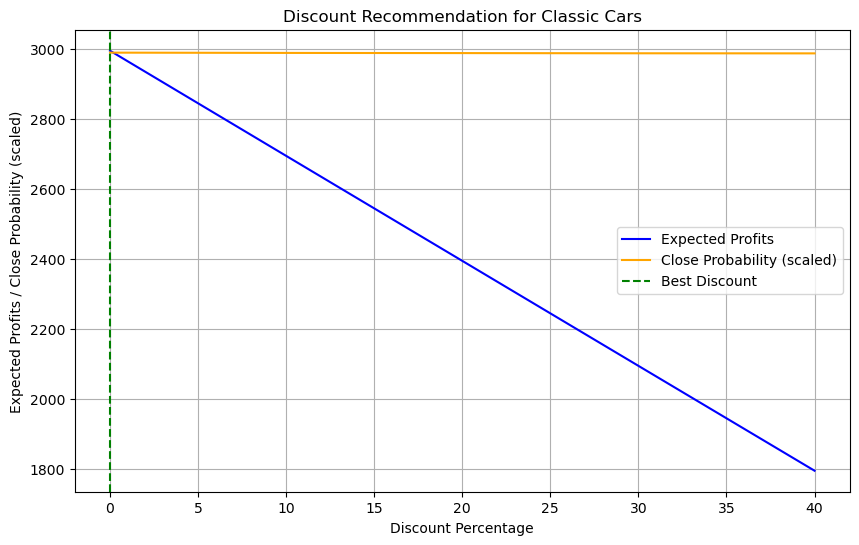

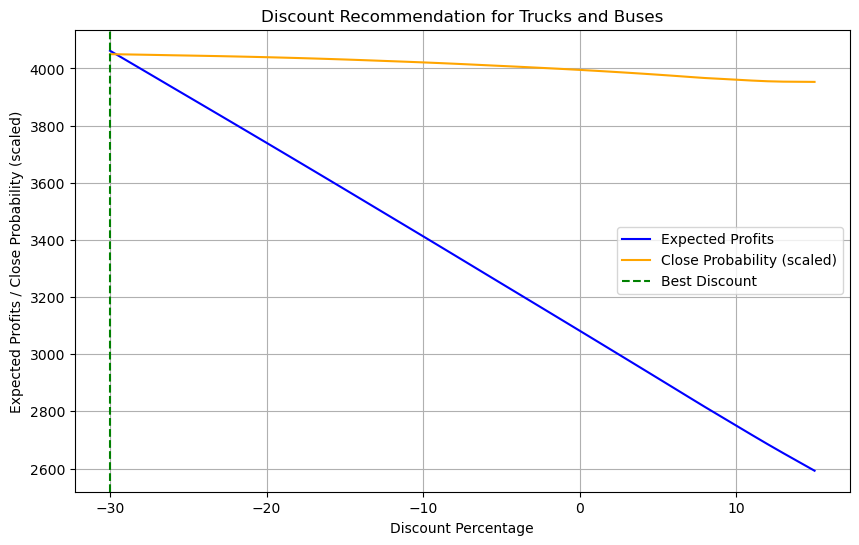

In [22]:
plot_recommendation_results(result, context)
plot_recommendation_results(result2, context2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


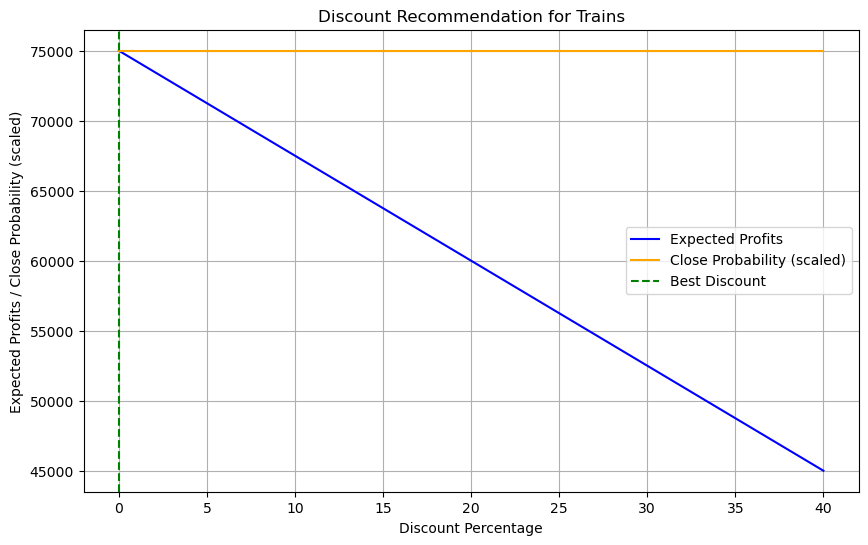

In [23]:
result3 = recommend_discount_for_context(model, context3)
result3["best_discount"], result3["best_expected_profits"]
plot_recommendation_results(result3, context3)


In [24]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Plot AUC
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid()

    plt.show()

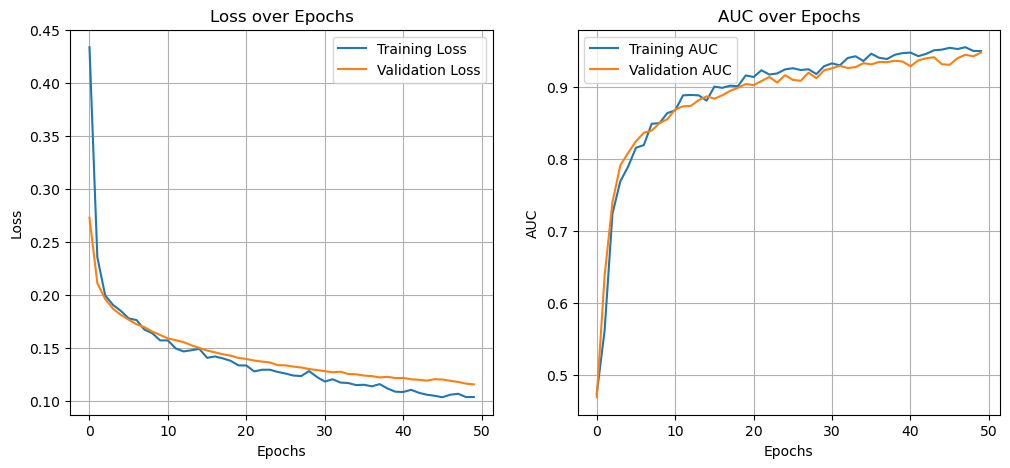

In [25]:
plot_history(history)

# Model 2
Include deal sizes and risk behaviors

#### Inspect the Data

In [26]:
print(df.shape)
print(df.columns)
print(df["STATUS"].value_counts(dropna=False))

(2823, 20)
Index(['ORDERDATE', 'YEAR_ID', 'MONTH_ID', 'QTR_ID', 'PRODUCTLINE',
       'QUANTITYORDERED', 'MSRP', 'PRICEEACH', 'DISCOUNT_PERCENTAGE',
       'DISCOUNT_PCT_CLIPPED', 'DISCOUNT_OUTLIER_FLAG', 'STATUS', 'IS_CLOSED',
       'DEAL_SIZE', 'LOG_DEAL_SIZE', 'PRICE_TO_MSRP_RATIO', 'IS_Q4',
       'IS_YEAR_END', 'DEAL_SIZE_BUCKETS', 'STATUS_CLASS'],
      dtype='object')
STATUS
Shipped       2617
Cancelled       60
Resolved        47
On Hold         44
In Process      41
Disputed        14
Name: count, dtype: int64


In [27]:
print(df["STATUS_CLASS"].value_counts())

STATUS_CLASS
2.0    2664
0.0      74
1.0      44
Name: count, dtype: int64


#### Setup Features and Targets

In [28]:
# Define Features and Target

FEATURES = [
    "PRODUCTLINE",
    "QUANTITYORDERED",
    "MSRP",
    "PRICEEACH",
    "DISCOUNT_PCT_CLIPPED",
    "MONTH_ID",
    "YEAR_ID",
    "QTR_ID",
    "LOG_DEAL_SIZE",
    "PRICE_TO_MSRP_RATIO"
]

TARGET = "STATUS_CLASS"

df = df.dropna(subset=FEATURES + [TARGET]).copy()

X_df = df[FEATURES]
y = df[TARGET].astype("int32").values

In [29]:
print(X_df.shape, y.shape)

(2782, 10) (2782,)


#### Split Data into Test and Training Sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape}, Testing samples: {X_test.shape}")

Training samples: (2086, 10), Testing samples: (696, 10)


#### Model Setup

In [31]:
BATCH_SIZE = 64

train_ds = df_to_dataset(X_train, y_train, shuffle=True)
val_ds = df_to_dataset(X_test, y_test, shuffle=False)

In [32]:
# Categorical Encoding for PRODUCTLINE
def productline_lookup_layer():
    lookup = tf.keras.layers.StringLookup(output_mode="one_hot")
    lookup.adapt(X_train["PRODUCTLINE"].astype(str).values)
    return lookup

productline_lookup = productline_lookup_layer()

# Numeric Normalization layer
numeric_cols = [
    "QUANTITYORDERED", "MSRP", "PRICEEACH", "DISCOUNT_PCT_CLIPPED",
    "MONTH_ID", "YEAR_ID", "QTR_ID", "LOG_DEAL_SIZE", "PRICE_TO_MSRP_RATIO"
]

normailzer = tf.keras.layers.Normalization()
normailzer.adapt(X_train[numeric_cols].values.astype("float32"))

In [33]:
df.head()

,ORDERDATE,YEAR_ID,MONTH_ID,QTR_ID,PRODUCTLINE,QUANTITYORDERED,MSRP,PRICEEACH,DISCOUNT_PERCENTAGE,DISCOUNT_PCT_CLIPPED,DISCOUNT_OUTLIER_FLAG,STATUS,IS_CLOSED,DEAL_SIZE,LOG_DEAL_SIZE,PRICE_TO_MSRP_RATIO,IS_Q4,IS_YEAR_END,DEAL_SIZE_BUCKETS,STATUS_CLASS
0,2003-02-24,2003,2,1,Motorcycles,30,95,95.70,-0.736842,-0.736842,0,Shipped,1,2871.00,7.962764,1.007368,0,0,Medium,2.0
1,2003-05-07,2003,5,2,Motorcycles,34,95,81.35,14.368421,14.368421,0,Shipped,1,2765.90,7.925483,0.856316,0,0,Medium,2.0
2,2003-07-01,2003,7,3,Motorcycles,41,95,94.74,0.273684,0.273684,0,Shipped,1,3884.34,8.264966,0.997263,0,0,Large,2.0
3,2003-08-25,2003,8,3,Motorcycles,45,95,83.26,12.357895,12.357895,0,Shipped,1,3746.70,8.228898,0.876421,0,0,Large,2.0
4,2003-10-10,2003,10,4,Motorcycles,49,95,100.00,-5.263158,-5.263158,0,Shipped,1,4900.00,8.497195,1.052632,1,0,Large,2.0


In [34]:
## Build the model
def build_status_model(
    features,
    numeric_cols,
    productline_lookup,
    normalizer,
    hidden_units=(64, 32),
    dropout_rate=0.25,
    n_classes=3,
    model_name="status_model",
):
    # Input layers
    inputs = {}
    for col in features:
        dtype = tf.string if col == "PRODUCTLINE" else tf.float32
        inputs[col] = keras.Input(shape=(1,), name=col, dtype=dtype)

    # Encode categorical
    productline_encoded = productline_lookup(inputs["PRODUCTLINE"])

    # Stack numeric -> cast -> normalize
    numeric_stack = layers.Concatenate()([inputs[c] for c in numeric_cols])
    numeric_stack = layers.Lambda(lambda t: tf.cast(t, tf.float32), name="cast_numeric")(
        numeric_stack
    )
    numeric_normalized = normalizer(numeric_stack)

    # Combine all features
    x = layers.Concatenate()([productline_encoded, numeric_normalized])

    # Dense network
    for i, units in enumerate(hidden_units):
        x = layers.Dense(units, activation="relu", name=f"dense_{i+1}")(x)
        x = layers.Dropout(dropout_rate, name=f"dropout_{i+1}")(x)

    # Visualize Normalized Numeric Data vs Raw Data
    compare_raw_vs_normalized(X_train[numeric_cols], pd.DataFrame(normalizer(X_train[numeric_cols]), columns=numeric_cols), numeric_cols)
    # Box Plot Comparison
    box_plot(X_train[numeric_cols], pd.DataFrame(normalizer(X_train[numeric_cols]), columns=numeric_cols), numeric_cols)
    # Summary Statistics Comparison
    summary_details(X_train[numeric_cols], pd.DataFrame(normalizer(X_train[numeric_cols]), columns=numeric_cols))

    # Output: multiclass
    outputs = layers.Dense(n_classes, activation="softmax", name="status_probs")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name=model_name)

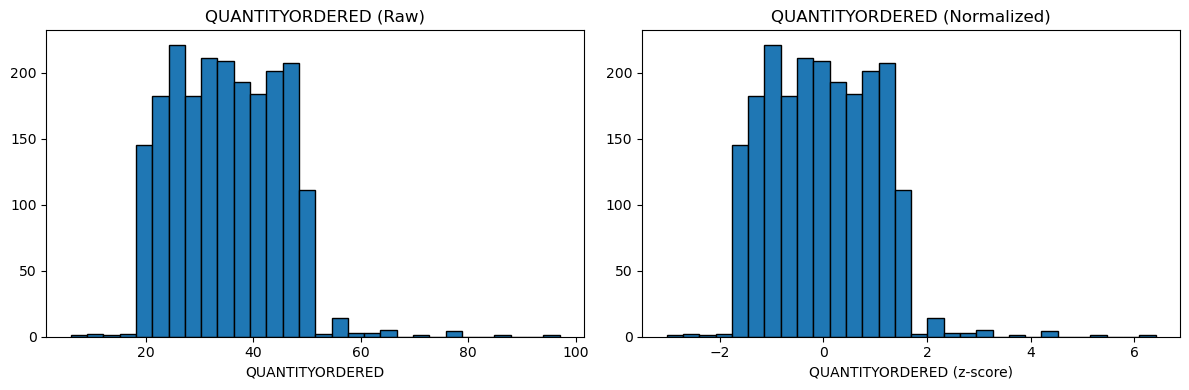

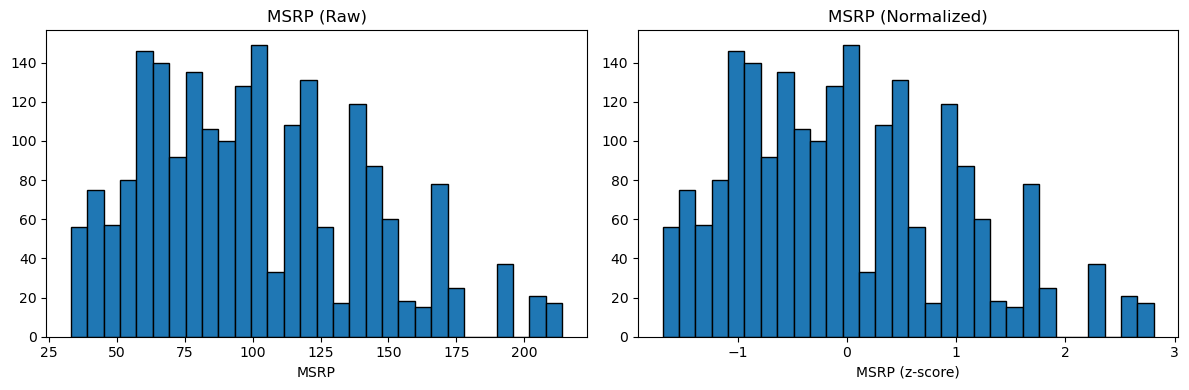

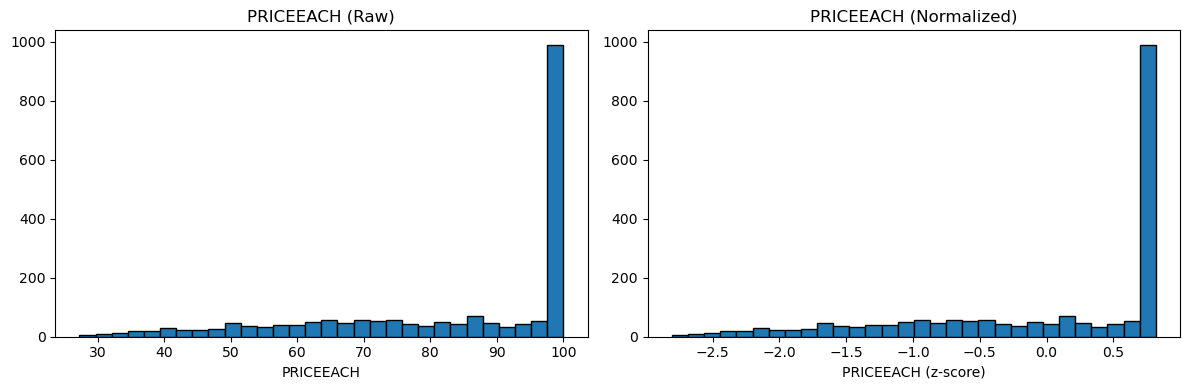

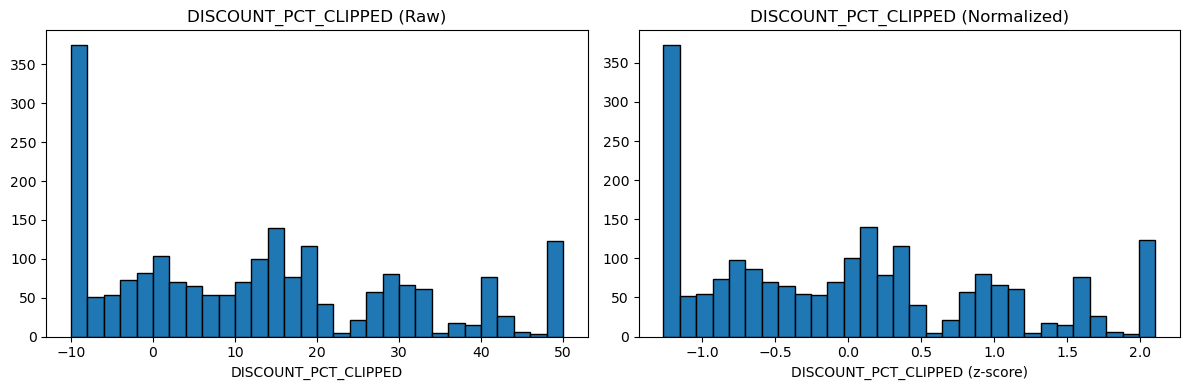

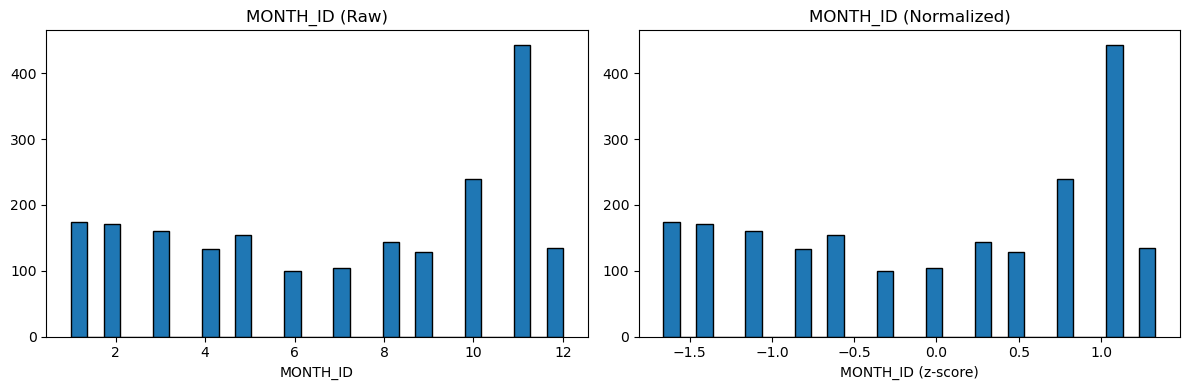

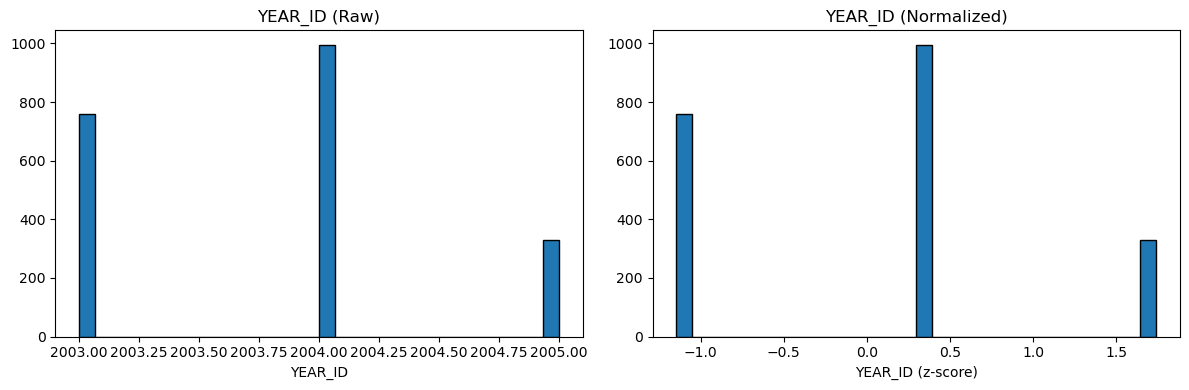

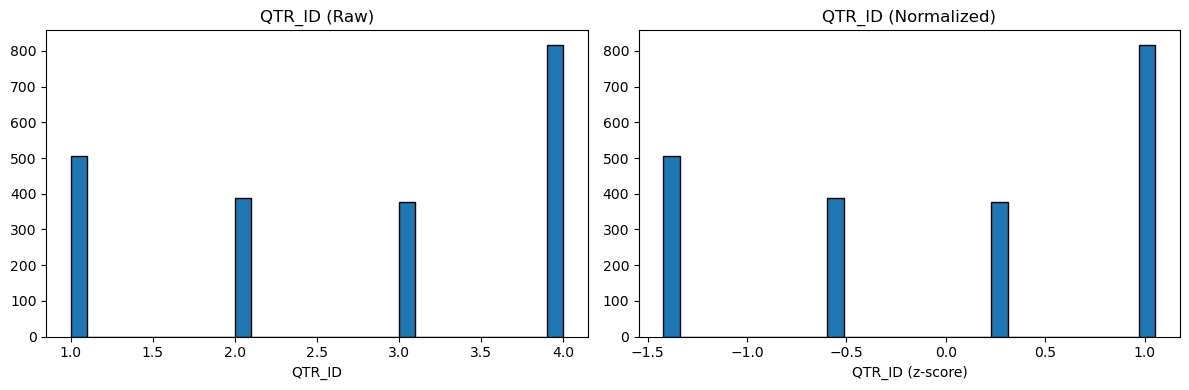

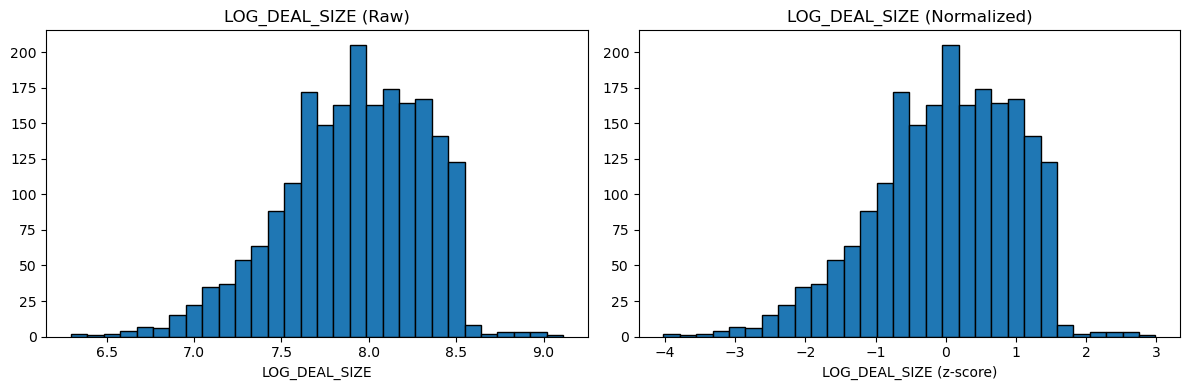

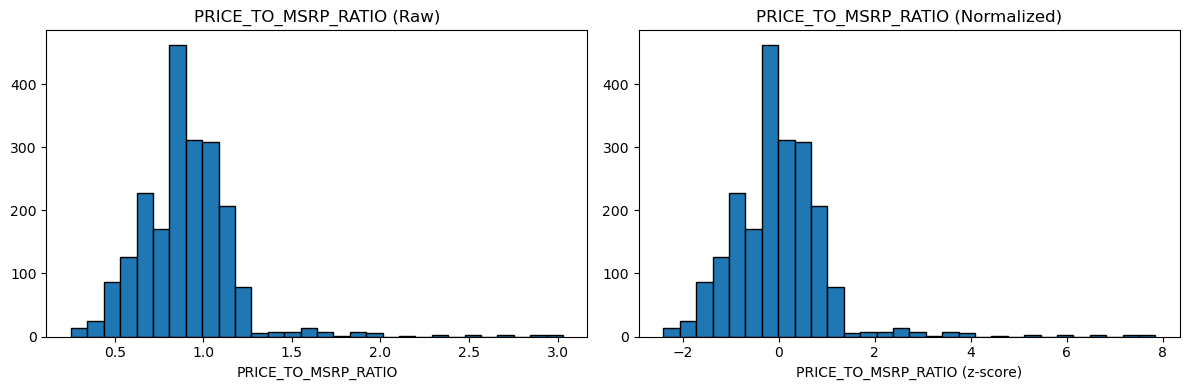

C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\2207555441.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


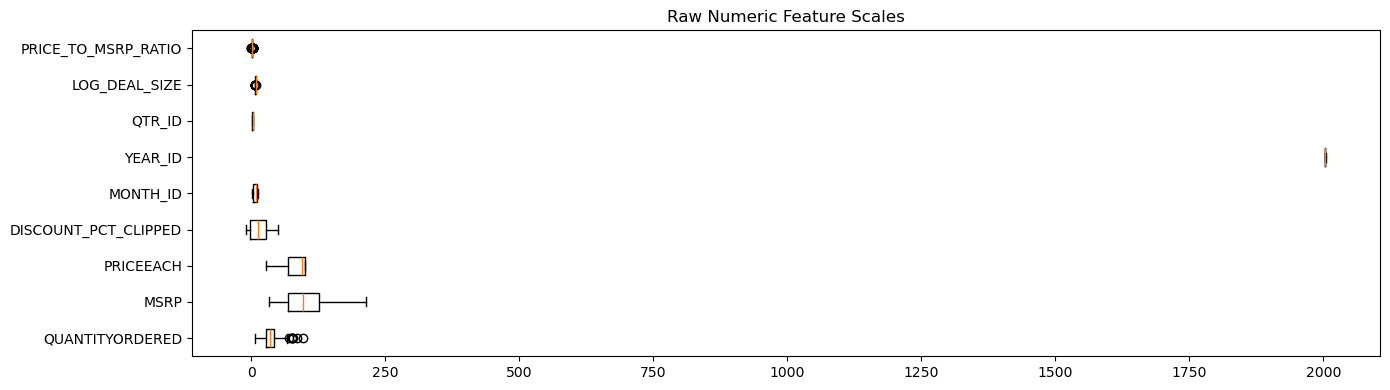

C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\2207555441.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


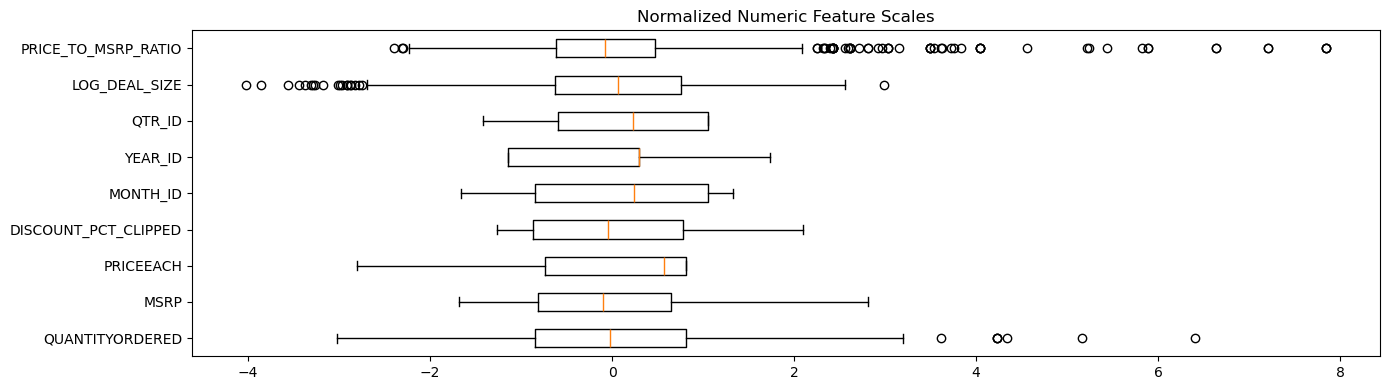

raw               normalized          
                             mean        std          mean       std
QUANTITYORDERED         35.169703   9.650038 -1.718991e-07  1.000237
MSRP                   100.897411  40.281420  9.692184e-08  1.000240
PRICEEACH               83.572028  20.103820 -7.863470e-08  1.000243
DISCOUNT_PCT_CLIPPED    12.519617  17.827690  3.748864e-08  1.000241
MONTH_ID                 7.104506   3.680737  6.857677e-08  1.000240
YEAR_ID               2003.794343   0.693503  4.573796e-05  1.000245
QTR_ID                   2.721956   1.211997 -1.174949e-07  1.000244
LOG_DEAL_SIZE            7.910610   0.401610  1.755565e-07  1.000239
PRICE_TO_MSRP_RATIO      0.903294   0.271216  1.917864e-07  1.000240

In [35]:
status_model = build_status_model(
    FEATURES,
    numeric_cols,
    productline_lookup,
    normailzer,
)

In [36]:
status_model.summary()

Model: "status_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ QUANTITYORDERED     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MSRP (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRICEEACH           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DISCOUNT_PCT_CLIPP… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MONTH_ID            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ YEAR_ID             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ QTR_ID (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LOG_DEAL_SIZE       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRICE_TO_MSRP_RATIO │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 9)         │          0 │ QUANTITYORDERED[… │
│ (Concatenate)       │                   │            │ MSRP[0][0],       │
│                     │                   │            │ PRICEEACH[0][0],  │
│                     │                   │            │ DISCOUNT_PCT_CLI… │
│                     │                   │            │ MONTH_ID[0][0],   │
│                     │                   │            │ YEAR_ID[0][0],    │
│                     │                   │            │ QTR_ID[0][0],     │
│                     │                   │            │ LOG_DEAL_SIZE[0]… │
│                     │                   │            │ PRICE_TO_MSRP_RA… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRODUCTLINE         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_numeric        │ (None, 9)         │          0 │ concatenate_2[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_1     │ (None, 8)         │          0 │ PRODUCTLINE[0][0] │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 9)         │         19 │ cast_numeric[0][… │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 17)        │          0 │ string_lookup_1[… │
│ (Concatenate)       │                   │            │ normalization_1[

 Total params: 3,350 (13.09 KB)

 Trainable params: 3,331 (13.01 KB)

 Non-trainable params: 19 (80.00 B)

#### Uncontrolled Model

In [37]:
status_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.SparseCategoricalCrossentropy(name="crossentropy"),
    ],
)

In [38]:
# Compute class weights to handle class imbalance
class_counts = Counter(y_train)
total = len(y_train)

# Compute weights: inverse frequency
class_weight = {
    cls: total / (len(class_counts) * count)
    for cls, count in class_counts.items()
}

# Class weights tell the optimizer “LOST mistakes matter more than their frequency suggests.
print("Class counts:", class_counts)
print("Class weights:", class_weight)

Class counts: Counter({np.int32(2): 1998, np.int32(0): 55, np.int32(1): 33})
Class weights: {np.int32(2): 0.34801468134801467, np.int32(0): 12.642424242424243, np.int32(1): 21.07070707070707}


In [39]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True
    )
]

histor_status_model = status_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight,
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.1937 - crossentropy: 1.2437 - loss: 1.1069 - val_accuracy: 0.4871 - val_crossentropy: 1.0244 - val_loss: 1.0244
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5369 - crossentropy: 0.9830 - loss: 0.9656 - val_accuracy: 0.7227 - val_crossentropy: 0.8963 - val_loss: 0.8963
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6486 - crossentropy: 0.9030 - loss: 0.9113 - val_accuracy: 0.7615 - val_crossentropy: 0.8320 - val_loss: 0.8320
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6654 - crossentropy: 0.8772 - loss: 0.9133 - val_accuracy: 0.7931 - val_crossentropy: 0.7921 - val_loss: 0.7921
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7416 - crossentropy: 0.7639 - loss: 0.8254 - val_accuracy: 0.8118 - val_crossentropy: 0.7128 - val_loss: 0.7128
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7301 - crossentropy: 0.7711 - loss: 0.8001 - val_accu

In [40]:
val_pred_probs = status_model.predict(val_ds)
val_pred = np.argmax(val_pred_probs, axis=1)

print("Validation Predictions:", confusion_matrix(y_test, val_pred))
print("Classification Report:\n", classification_report(y_test, val_pred))  

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Validation Predictions: [[  6   4   9]
 [  2   7   2]
 [ 52  62 552]]
Classification Report:
               precision    recall  f1-score   support

           0       0.10      0.32      0.15        19
           1       0.10      0.64      0.17        11
           2       0.98      0.83      0.90       666

    accuracy                           0.81       696
   macro avg       0.39      0.59      0.41       696
weighted avg       0.94      0.81      0.87       696



##### Plot Gradient Decent

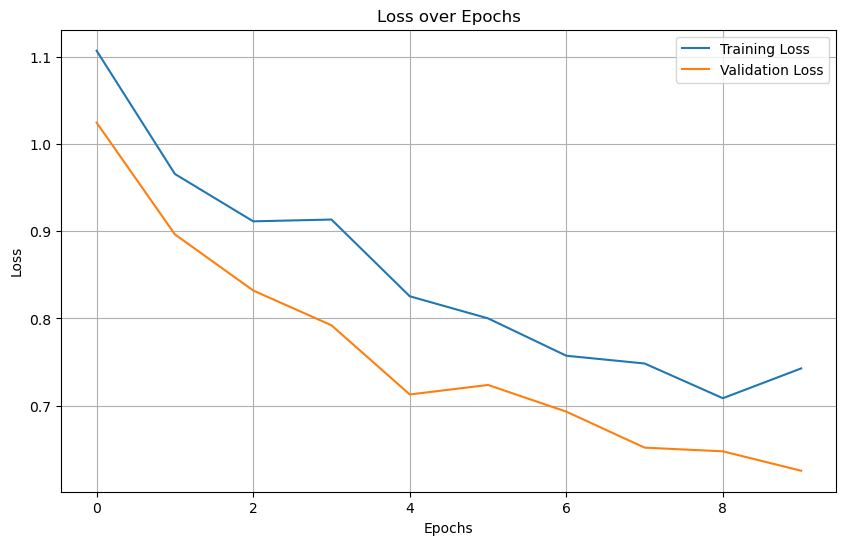

In [41]:
# Plot training  and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(histor_status_model.history['loss'], label='Training Loss')
plt.plot(histor_status_model.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

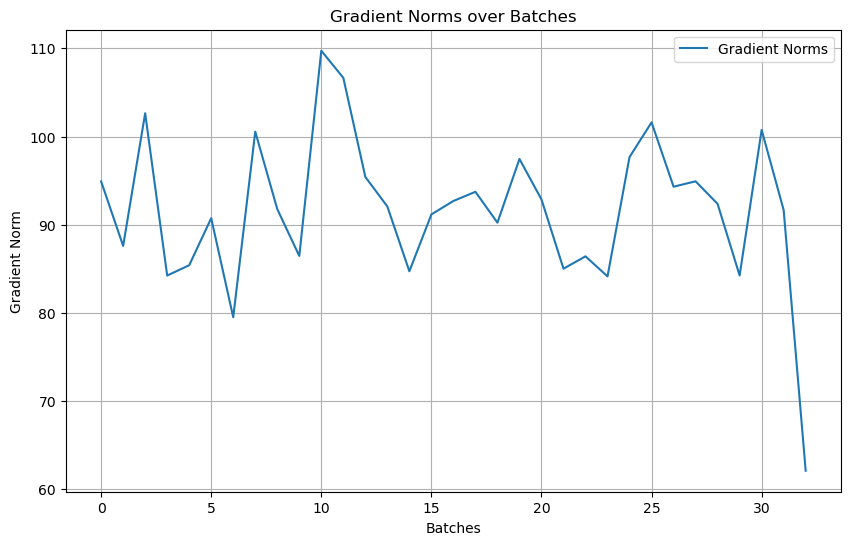

In [42]:
# Compute Gradient Norms for each batches
@tf.function
def grad_norm(model, x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    return tf.linalg.global_norm(grads)

# Plot Gradient Norms over baches
gradient_norms = []
for x_batch, y_batch in train_ds:
    norm = grad_norm(status_model, x_batch, y_batch)
    gradient_norms.append(norm.numpy())
plt.figure(figsize=(10, 6))
plt.plot(gradient_norms, label='Gradient Norms')
plt.title('Gradient Norms over Batches')
plt.xlabel('Batches')
plt.ylabel('Gradient Norm')
plt.legend()
plt.grid()
plt.show()


#### Controlled Test Model

Epoch 1/50 | train_loss=0.4104 train_acc=0.9132 | val_loss=0.2112 val_acc=0.9569 | grad_norm_mean=0.86 grad_norm_max=1.58
Epoch 2/50 | train_loss=0.1967 train_acc=0.9578 | val_loss=0.1804 val_acc=0.9569 | grad_norm_mean=0.33 grad_norm_max=0.44
Epoch 3/50 | train_loss=0.1855 train_acc=0.9569 | val_loss=0.1781 val_acc=0.9569 | grad_norm_mean=0.30 grad_norm_max=0.81
Epoch 4/50 | train_loss=0.1784 train_acc=0.9554 | val_loss=0.1742 val_acc=0.9569 | grad_norm_mean=0.30 grad_norm_max=0.53
Epoch 5/50 | train_loss=0.1671 train_acc=0.9578 | val_loss=0.1721 val_acc=0.9569 | grad_norm_mean=0.29 grad_norm_max=0.59
Epoch 6/50 | train_loss=0.1546 train_acc=0.9573 | val_loss=0.1701 val_acc=0.9569 | grad_norm_mean=0.28 grad_norm_max=0.55
Epoch 7/50 | train_loss=0.1629 train_acc=0.9593 | val_loss=0.1688 val_acc=0.9569 | grad_norm_mean=0.28 grad_norm_max=0.62
Epoch 8/50 | train_loss=0.1553 train_acc=0.9583 | val_loss=0.1675 val_acc=0.9569 | grad_norm_mean=0.30 grad_norm_max=0.78
Epoch 9/50 | train_loss=

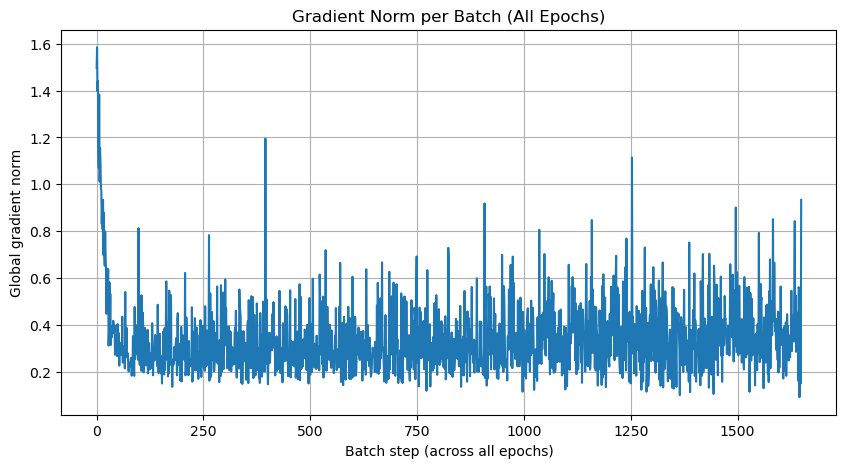

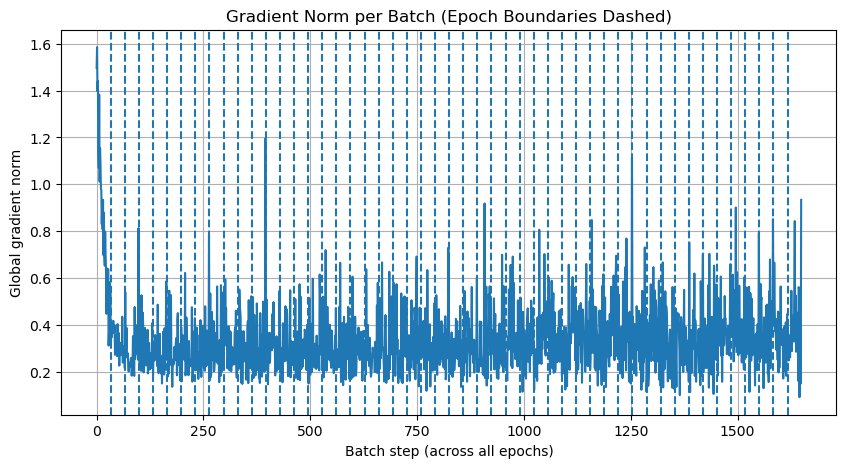

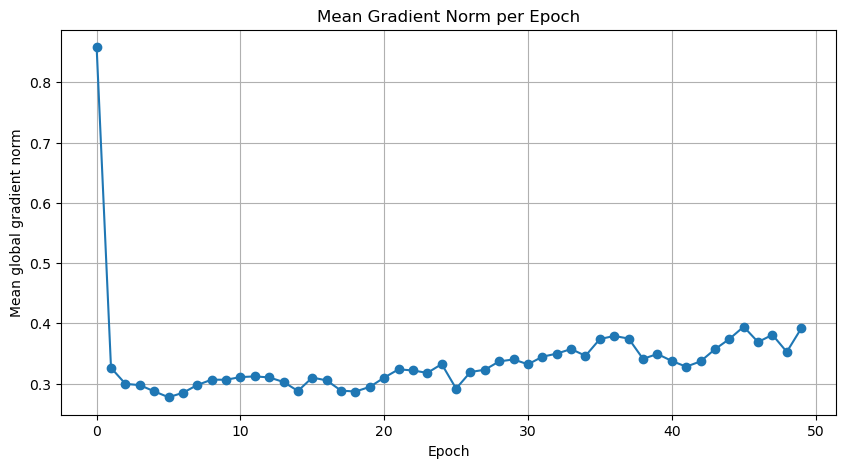

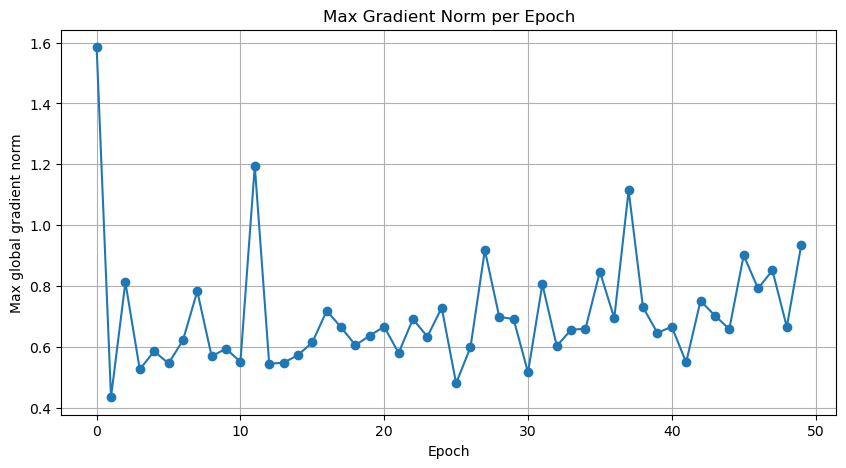

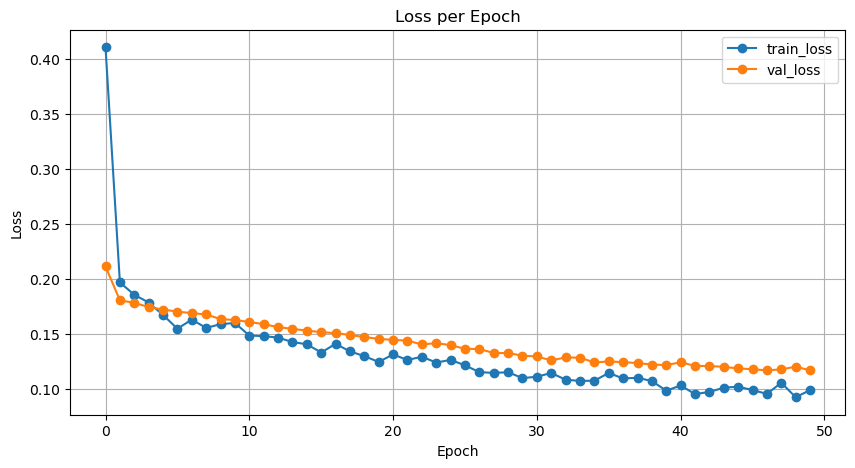

In [68]:
# --- Full, runnable example: train with a custom loop + log gradient norms per batch ---
# Assumes you already have:
#   - status_model  (built model)
#   - train_ds      (tf.data.Dataset yielding (x_batch, y_batch))
#   - val_ds        (optional; tf.data.Dataset yielding (x_batch, y_batch))
# If you don't have val_ds, you can set val_ds = None.

# -----------------------------
# 1) Loss + optimizer + metrics
# -----------------------------
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
val_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="val_acc")

# -----------------------------
# 2) One training step that returns loss + gradient norm
# -----------------------------
@tf.function
def train_step(model, x_batch, y_batch):
    with tf.GradientTape() as tape:
        y_pred = model(x_batch, training=True)
        loss_value = loss_fn(y_batch, y_pred)

    grads = tape.gradient(loss_value, model.trainable_weights)

    # Global gradient norm (single scalar for the whole model)
    grad_norm_value = tf.linalg.global_norm(grads)

    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc.update_state(y_batch, y_pred)

    return loss_value, grad_norm_value

@tf.function
def val_step(model, x_batch, y_batch):
    y_pred = model(x_batch, training=False)
    loss_value = loss_fn(y_batch, y_pred)
    val_acc.update_state(y_batch, y_pred)
    return loss_value

# -----------------------------
# 3) Training loop: record per-batch gradient norms + losses
# -----------------------------
def train_with_gradient_logging(model, train_ds, val_ds=None, epochs=5):
    history = {
        "train_loss_per_batch": [],
        "grad_norm_per_batch": [],
        "batch_epoch_index": [],          # which epoch each batch belongs to
        "train_loss_per_epoch": [],
        "train_acc_per_epoch": [],
        "val_loss_per_epoch": [],
        "val_acc_per_epoch": [],
        "grad_norm_mean_per_epoch": [],
        "grad_norm_max_per_epoch": [],
    }

    for epoch in range(epochs):
        train_acc.reset_state()
        if val_ds is not None:
            val_acc.reset_state()

        epoch_train_losses = []
        epoch_grad_norms = []

        # ---- Train over batches ----
        for batch_idx, (x_batch, y_batch) in enumerate(train_ds):
            loss_value, grad_norm_value = train_step(model, x_batch, y_batch)

            loss_float = float(loss_value.numpy())
            norm_float = float(grad_norm_value.numpy())

            history["train_loss_per_batch"].append(loss_float)
            history["grad_norm_per_batch"].append(norm_float)
            history["batch_epoch_index"].append(epoch)

            epoch_train_losses.append(loss_float)
            epoch_grad_norms.append(norm_float)

        # Per-epoch summaries
        history["train_loss_per_epoch"].append(float(np.mean(epoch_train_losses)))
        history["train_acc_per_epoch"].append(float(train_acc.result().numpy()))
        history["grad_norm_mean_per_epoch"].append(float(np.mean(epoch_grad_norms)))
        history["grad_norm_max_per_epoch"].append(float(np.max(epoch_grad_norms)))

        # ---- Validation (optional) ----
        if val_ds is not None:
            epoch_val_losses = []
            for x_batch, y_batch in val_ds:
                val_loss_value = val_step(model, x_batch, y_batch)
                epoch_val_losses.append(float(val_loss_value.numpy()))

            history["val_loss_per_epoch"].append(float(np.mean(epoch_val_losses)))
            history["val_acc_per_epoch"].append(float(val_acc.result().numpy()))
        else:
            history["val_loss_per_epoch"].append(None)
            history["val_acc_per_epoch"].append(None)

        # Print epoch summary
        if val_ds is not None:
            print(
                f"Epoch {epoch+1}/{epochs} | "
                f"train_loss={history['train_loss_per_epoch'][-1]:.4f} "
                f"train_acc={history['train_acc_per_epoch'][-1]:.4f} | "
                f"val_loss={history['val_loss_per_epoch'][-1]:.4f} "
                f"val_acc={history['val_acc_per_epoch'][-1]:.4f} | "
                f"grad_norm_mean={history['grad_norm_mean_per_epoch'][-1]:.2f} "
                f"grad_norm_max={history['grad_norm_max_per_epoch'][-1]:.2f}"
            )
        else:
            print(
                f"Epoch {epoch+1}/{epochs} | "
                f"train_loss={history['train_loss_per_epoch'][-1]:.4f} "
                f"train_acc={history['train_acc_per_epoch'][-1]:.4f} | "
                f"grad_norm_mean={history['grad_norm_mean_per_epoch'][-1]:.2f} "
                f"grad_norm_max={history['grad_norm_max_per_epoch'][-1]:.2f}"
            )

    return history

# -----------------------------
# 4) Train and collect logs
# -----------------------------
EPOCHS = 50
history = train_with_gradient_logging(status_model, train_ds, val_ds=val_ds, epochs=EPOCHS)

# -----------------------------
# 5) Plot gradient norms per batch (all epochs)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history["grad_norm_per_batch"])
plt.xlabel("Batch step (across all epochs)")
plt.ylabel("Global gradient norm")
plt.title("Gradient Norm per Batch (All Epochs)")
plt.grid(True)
plt.show()

# Optional: show epoch boundaries on the per-batch plot
plt.figure(figsize=(10, 5))
plt.plot(history["grad_norm_per_batch"])
prev_epoch = history["batch_epoch_index"][0]
for i, ep in enumerate(history["batch_epoch_index"]):
    if ep != prev_epoch:
        plt.axvline(i, linestyle="--")
        prev_epoch = ep
plt.xlabel("Batch step (across all epochs)")
plt.ylabel("Global gradient norm")
plt.title("Gradient Norm per Batch (Epoch Boundaries Dashed)")
plt.grid(True)
plt.show()

# -----------------------------
# 6) Plot per-epoch mean/max gradient norm (convergence view)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history["grad_norm_mean_per_epoch"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Mean global gradient norm")
plt.title("Mean Gradient Norm per Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history["grad_norm_max_per_epoch"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Max global gradient norm")
plt.title("Max Gradient Norm per Epoch")
plt.grid(True)
plt.show()
# -----------------------------
# 7) (Optional) Plot loss per epoch (train vs val)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss_per_epoch"], marker="o", label="train_loss")
if history["val_loss_per_epoch"][0] is not None:
    plt.plot(history["val_loss_per_epoch"], marker="o", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


#### Plot Risk Behaviors Over Discount 

In [44]:
status_model.evaluate(val_ds)
print(np.mean(val_pred_probs, axis=0))

 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8594 - crossentropy: 0.6764 - loss: 0.6764

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8118 - crossentropy: 0.7128 - loss: 0.7128 
[0.2922093  0.18609382 0.5216969 ]


In [45]:
# Plot average predicted probabilities per class

mean_probs = np.mean(val_pred_probs, axis=0)

print("Average predicted probabilities:")
print(f"P(LOST)    = {mean_probs[0]:.3f}")
print(f"P(PENDING) = {mean_probs[1]:.3f}")
print(f"P(WON)     = {mean_probs[2]:.3f}")

Average predicted probabilities:
P(LOST)    = 0.292
P(PENDING) = 0.186
P(WON)     = 0.522


In [46]:
df_val = X_test.copy()

df_val["P_LOST"] = val_pred_probs[:, 0]
df_val["P_PENDING"] = val_pred_probs[:, 1]
df_val["P_WON"] = val_pred_probs[:, 2]

In [47]:
df_val["DISCOUNT_BIN"] = pd.cut(
    df_val["DISCOUNT_PCT_CLIPPED"],
    bins=20
)

In [48]:
prob_by_discount = (
    df_val
    .groupby("DISCOUNT_BIN")[["P_LOST", "P_PENDING", "P_WON"]]
    .mean()
    .reset_index()
)

C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\851815710.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DISCOUNT_BIN")[["P_LOST", "P_PENDING", "P_WON"]]


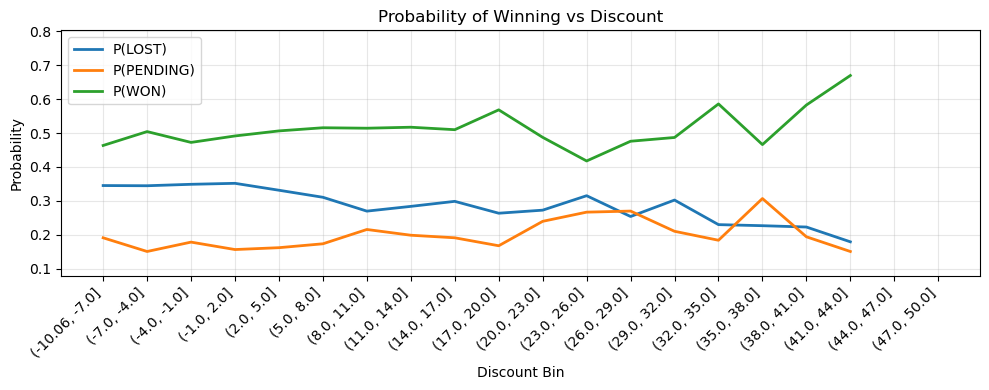

In [49]:

def plot_win_probability_vs_discount(
    prob_by_discount,
    x_col="DISCOUNT_BIN",
    figsize=(10, 4),
    rotate_xticks=45,
    title="Probability of Winning vs Discount",
):
    plot_df = prob_by_discount.copy()

    # Use DISCOUNT_BIN labels if available; otherwise fall back to the index
    if x_col in plot_df.columns:
        x = plot_df[x_col].astype(str)
    else:
        x = plot_df.index

    plt.figure(figsize=figsize)
    
    # Plot all three lines without markers for cleaner look
    plt.plot(x, plot_df["P_LOST"].values, label="P(LOST)", linewidth=2)
    plt.plot(x, plot_df["P_PENDING"].values, label="P(PENDING)", linewidth=2)
    plt.plot(x, plot_df["P_WON"].values, label="P(WON)", linewidth=2)
    
    plt.xlabel("Discount Bin" if x_col in plot_df.columns else "Index")
    plt.ylabel("Probability")
    plt.title(title)
    plt.legend()

    if x_col in plot_df.columns:
        plt.xticks(rotation=rotate_xticks, ha="right")

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# usage:
plot_win_probability_vs_discount(prob_by_discount)

In [50]:
def calculate_and_plot_expected_profit(
    df_with_predictions,
    deal_sizes,
    pending_value_factor=0.4,
    bins=20,
    figsize=(10, 4),
    title="Expected Profit vs Discount"
):
    """
    Calculate expected profit based on model predictions and plot by discount bins.
    
    Parameters:
    -----------
    df_with_predictions : pd.DataFrame
        DataFrame containing P_WON, P_PENDING, and DISCOUNT_PCT_CLIPPED columns
    deal_sizes : pd.Series or array-like
        Deal sizes corresponding to each row (e.g., df["DEAL_SIZE"])
    pending_value_factor : float, default=0.4
        Discount factor for pending deals (0-1). Represents expected value of pending deals.
    bins : int, default=20
        Number of bins for grouping discount percentages
    figsize : tuple, default=(10, 4)
        Figure size for the plot
    title : str
        Plot title
        
    Returns:
    --------
    pd.DataFrame
        Aggregated expected profit by discount bin
    """
    df = df_with_predictions.copy()
    
    # Convert deal_sizes to numpy array to avoid index alignment issues
    if hasattr(deal_sizes, 'values'):
        deal_sizes_array = deal_sizes.values
    else:
        deal_sizes_array = np.array(deal_sizes)
    
    # Calculate expected profit per deal
    df["EXPECTED_PROFIT"] = (
        df["P_WON"] * deal_sizes_array +
        df["P_PENDING"] * pending_value_factor * deal_sizes_array
    )
    
    # Create discount bins
    df["DISCOUNT_BIN"] = pd.cut(df["DISCOUNT_PCT_CLIPPED"], bins=bins)
    
    # Aggregate by discount bin
    expected_profit_by_discount = (
        df
        .groupby("DISCOUNT_BIN")["EXPECTED_PROFIT"]
        .mean()
        .reset_index()
    )
    
    # Plot
    plt.figure(figsize=figsize)
    plt.plot(
        expected_profit_by_discount.index,
        expected_profit_by_discount["EXPECTED_PROFIT"],
        linewidth=2,
        marker='o'
    )
    plt.xlabel("Discount Bin")
    plt.ylabel("Expected Profit")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return expected_profit_by_discount


C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\1322596834.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DISCOUNT_BIN")["EXPECTED_PROFIT"]


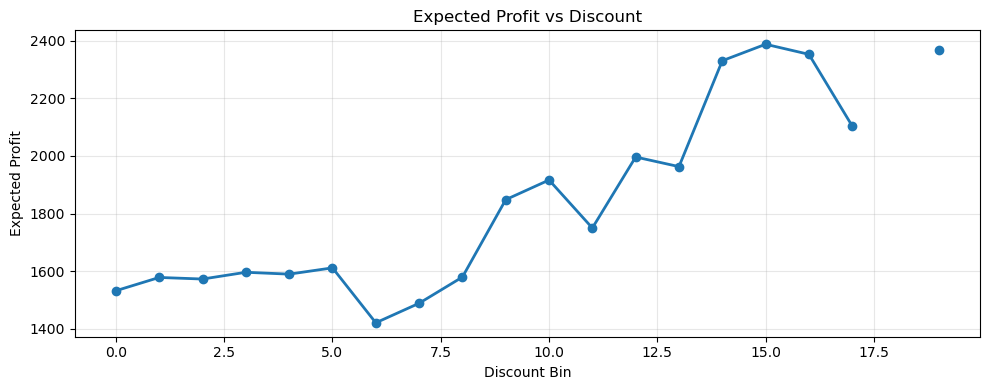

In [51]:
# Usage example:
# Note: Use .values or .iloc[y_test indices] to ensure alignment
expected_profit_by_discount = calculate_and_plot_expected_profit(
    df_val,
    deal_sizes=df.loc[df_val.index, "DEAL_SIZE"],  # Align indices
    pending_value_factor=0.4,
    bins=20
)

## Stress Test

### Option A

Why this is the best first mock

You control everything except the one variable you want to study (usually discount). This lets you isolate:

How predictions change as discount changes

Whether the model output is stable/sensible

Whether probability mass shifts between WON/PENDING/LOST

#### Step A1 — Pick a “baseline” deal from real data
Decision: We base scenarios on a real row so feature combinations are realistic.

In [52]:
baseline = df_val.sample(1, random_state=42).copy()
baseline


,PRODUCTLINE,QUANTITYORDERED,MSRP,PRICEEACH,DISCOUNT_PCT_CLIPPED,MONTH_ID,YEAR_ID,QTR_ID,LOG_DEAL_SIZE,PRICE_TO_MSRP_RATIO,P_LOST,P_PENDING,P_WON,DISCOUNT_BIN
2005,Planes,29,68,69.6,-2.352941,1,2004,1,7.610556,1.023529,0.330344,0.153586,0.51607,"(-4.0, -1.0]"


#### Step A2 — Create a sweep of discounts for that same deal
Decision: This tests the model as a “discount lever,” holding everything else constant.

In [53]:
discount_grid = np.array([-5, 0, 5, 10, 15, 20, 25, 30, 35, 40], dtype=float)

scenarios = pd.concat([baseline]*len(discount_grid), ignore_index=True)
scenarios["DISCOUNT_PCT_CLIPPED"] = discount_grid


#### Step A3 — Predict probabilities
Your model expects a dict of feature arrays (because you built it from named Keras Inputs).

In [54]:
FEATURES = [
    "PRODUCTLINE",
    "DISCOUNT_PCT_CLIPPED",
    "LOG_DEAL_SIZE",
    "PRICE_TO_MSRP_RATIO",
    "QUANTITYORDERED",
    "MSRP",
    "PRICEEACH",
    "MONTH_ID",
    "QTR_ID",
    "YEAR_ID",
]

X_scenarios = {col: scenarios[col].astype(str).values if col=="PRODUCTLINE"
               else scenarios[col].astype("float32").values
               for col in FEATURES}

pred = status_model.predict(X_scenarios, verbose=0)  # shape (n, 3)

In [55]:
X_scenarios

{'PRODUCTLINE': array(['Planes', 'Planes', 'Planes', 'Planes', 'Planes', 'Planes',
        'Planes', 'Planes', 'Planes', 'Planes'], dtype=object),
 'DISCOUNT_PCT_CLIPPED': array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.], dtype=float32),
 'LOG_DEAL_SIZE': array([7.6105556, 7.6105556, 7.6105556, 7.6105556, 7.6105556, 7.6105556,
        7.6105556, 7.6105556, 7.6105556, 7.6105556], dtype=float32),
 'PRICE_TO_MSRP_RATIO': array([1.0235294, 1.0235294, 1.0235294, 1.0235294, 1.0235294, 1.0235294,
        1.0235294, 1.0235294, 1.0235294, 1.0235294], dtype=float32),
 'QUANTITYORDERED': array([29., 29., 29., 29., 29., 29., 29., 29., 29., 29.], dtype=float32),
 'MSRP': array([68., 68., 68., 68., 68., 68., 68., 68., 68., 68.], dtype=float32),
 'PRICEEACH': array([69.6, 69.6, 69.6, 69.6, 69.6, 69.6, 69.6, 69.6, 69.6, 69.6],
       dtype=float32),
 'MONTH_ID': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'QTR_ID': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=floa

#### Step A4 — Put results into a readable table

In [56]:
results = scenarios[["DISCOUNT_PCT_CLIPPED"]].copy()
results["P_LOST"] = pred[:, 0]
results["P_PENDING"] = pred[:, 1]
results["P_WON"] = pred[:, 2]
results


,DISCOUNT_PCT_CLIPPED,P_LOST,P_PENDING,P_WON
0,-5.0,0.334503,0.155492,0.510005
1,0.0,0.326275,0.151795,0.521929
2,5.0,0.321731,0.152052,0.526218
3,10.0,0.311178,0.153158,0.535664
4,15.0,0.299207,0.153848,0.546944
5,20.0,0.288734,0.154769,0.556496
6,25.0,0.280379,0.156459,0.563162
7,30.0,0.273255,0.159534,0.567210
8,35.0,0.272412,0.163610,0.563978
9,40.0,0.270729,0.163741,0.565530


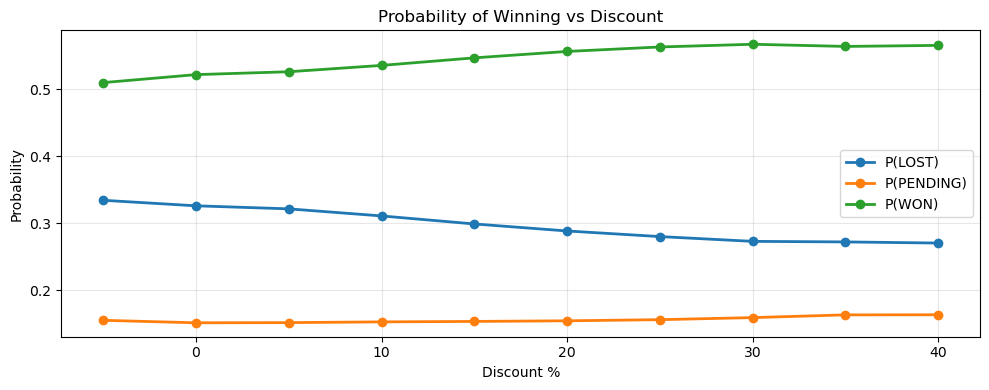

In [57]:
# Plot the discount sweep
plt.figure(figsize=(10, 4))
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["P_LOST"], label="P(LOST)", linewidth=2, marker='o')
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["P_PENDING"], label="P(PENDING)", linewidth=2, marker='o')
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["P_WON"], label="P(WON)", linewidth=2, marker='o')
plt.xlabel("Discount %")
plt.ylabel("Probability")
plt.title("Probability of Winning vs Discount")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\1322596834.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DISCOUNT_BIN")["EXPECTED_PROFIT"]


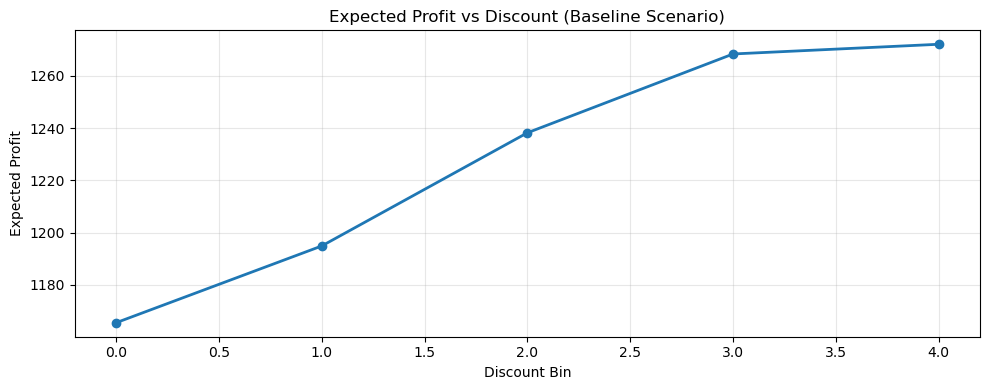

In [58]:
# Create a DataFrame with predictions for the expected profit function
results_with_predictions = results.copy()  # Already has DISCOUNT_PCT_CLIPPED, P_WON, P_PENDING
3
# Get the deal size from baseline (same for all scenarios since they're all the same deal)
baseline_deal_size = df.loc[baseline.index, "DEAL_SIZE"].values[0]
deal_sizes_for_scenarios = np.full(len(results_with_predictions), baseline_deal_size)

# Calculate and plot expected profit
expected_profit_results = calculate_and_plot_expected_profit(
    results_with_predictions,
    deal_sizes=deal_sizes_for_scenarios,
    pending_value_factor=0.4,
    bins=5,  # Fewer bins since we only have 10 discount points
    title="Expected Profit vs Discount (Baseline Scenario)"
)

In [59]:
results_with_predictions.shape

(10, 4)

### Option B

Why we do this

Hand-crafted scenarios are great, but they’re only a few points. Synthetic sampling lets you test hundreds of “new” deals without needing new real data.

Key warning: If you sample unrealistic combinations (like huge MSRP + tiny price + negative deal size), the model output becomes meaningless. So we sample from real distributions.

#### B1 — Bootstrap from real rows + perturb a little
Decision: This creates “new” deals that live near the training manifold.

In [60]:
rng = np.random.default_rng(42)

synthetic = df_val.sample(200, replace=True, random_state=42).copy()

# Small perturbations to numeric features (keep realistic)
def jitter(series, pct=0.05):
    noise = rng.normal(0, pct, size=len(series))
    return series * (1 + noise)

for col in ["LOG_DEAL_SIZE", "PRICE_TO_MSRP_RATIO", "PRICEEACH", "MSRP"]:
    synthetic[col] = jitter(synthetic[col].astype(float), pct=0.03)

# Randomize discounts within observed range (clip)
lo, hi = df_val["DISCOUNT_PCT_CLIPPED"].quantile([0.01, 0.99])
synthetic["DISCOUNT_PCT_CLIPPED"] = rng.uniform(lo, hi, size=len(synthetic))


### Predict

In [61]:
X_syn = {col: synthetic[col].astype(str).values if col=="PRODUCTLINE"
         else synthetic[col].astype("float32").values
         for col in FEATURES}

syn_pred = status_model.predict(X_syn, verbose=0)

synthetic["P_LOST"] = syn_pred[:, 0]
synthetic["P_PENDING"] = syn_pred[:, 1]
synthetic["P_WON"] = syn_pred[:, 2]

In [62]:
synthetic[["P_LOST", "P_PENDING", "P_WON"]].describe()

,P_LOST,P_PENDING,P_WON
count,200.000000,200.000000,200.000000
mean,0.286984,0.192156,0.520861
std,0.084624,0.131868,0.152647
min,0.069596,0.031112,0.077422
25%,0.234108,0.096700,0.434225
50%,0.290846,0.153574,0.513949
75%,0.349854,0.251098,0.613345
max,0.463338,0.741012,0.855679


C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\2476741865.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DISCOUNT_BIN")[["P_LOST", "P_PENDING", "P_WON"]]


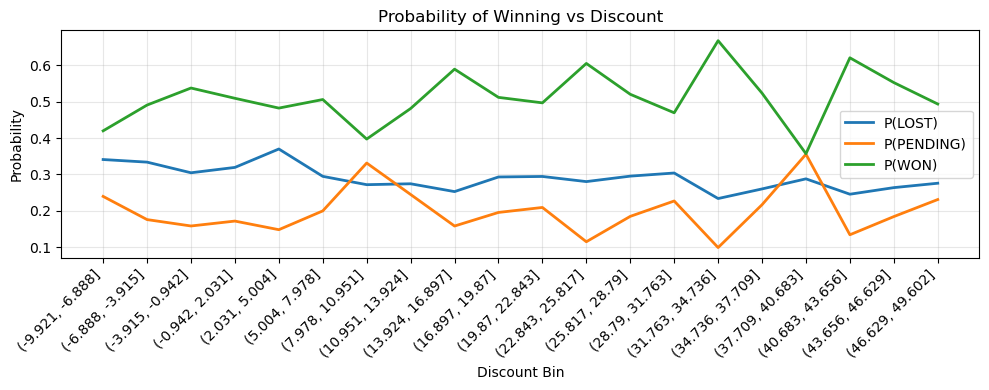

C:\Users\pwong\AppData\Local\Temp\ipykernel_28652\1322596834.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("DISCOUNT_BIN")["EXPECTED_PROFIT"]


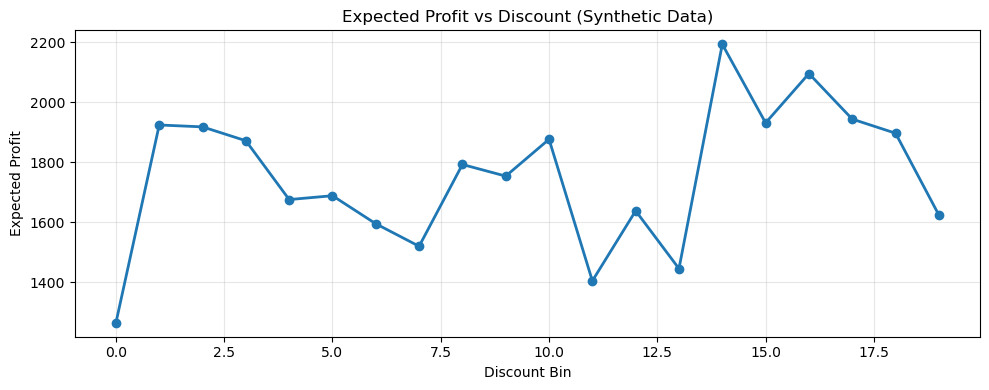

,DISCOUNT_BIN,EXPECTED_PROFIT
0,"(-9.921, -6.888]",1264.843524
1,"(-6.888, -3.915]",1924.305379
2,"(-3.915, -0.942]",1918.012638
3,"(-0.942, 2.031]",1871.769236
4,"(2.031, 5.004]",1675.625455
5,"(5.004, 7.978]",1688.517086
6,"(7.978, 10.951]",1595.023429
7,"(10.951, 13.924]",1519.985019
8,"(13.924, 16.897]",1792.615582
9,"(16.897, 19.87]",1753.828193


In [63]:
# Bin the synthetic data by discount
synthetic["DISCOUNT_BIN"] = pd.cut(
    synthetic["DISCOUNT_PCT_CLIPPED"],
    bins=20
)

# Aggregate by discount bin
synthetic_prob_by_discount = (
    synthetic
    .groupby("DISCOUNT_BIN")[["P_LOST", "P_PENDING", "P_WON"]]
    .mean()
    .reset_index()
)

# Plot the aggregated data
plot_win_probability_vs_discount(synthetic_prob_by_discount)
calculate_and_plot_expected_profit(
    synthetic,
    deal_sizes=df.loc[synthetic.index, "DEAL_SIZE"],  # Get DEAL_SIZE from original df
    pending_value_factor=0.4,
    bins=20,
    title="Expected Profit vs Discount (Synthetic Data)"
)

### Add one more check: does the model “break” on weird inputs?

In [64]:
stress = baseline.copy()
stress["DISCOUNT_PCT_CLIPPED"] = 50.0  # extreme
stress["LOG_DEAL_SIZE"] = stress["LOG_DEAL_SIZE"] + 2.0  # much larger deal

X_stress = {col: stress[col].astype(str).values if col=="PRODUCTLINE"
            else stress[col].astype("float32").values
            for col in FEATURES}

stress_pred = status_model.predict(X_stress, verbose=0)


Stress test predictions:
      DISCOUNT_PCT_CLIPPED  LOG_DEAL_SIZE    P_LOST  P_PENDING    P_WON
2005                  50.0       9.610556  0.104764   0.083556  0.81168

Baseline deal size: $2,018.40
Stress deal size (e^2 larger): $14,914.07

Stress Test Expected Profit:
  P(WON) = 0.812
  P(PENDING) = 0.084
  P(LOST) = 0.105
  Expected Profit = $12,603.92
  Profit Margin = 84.5% of deal size
  (at 50% discount)


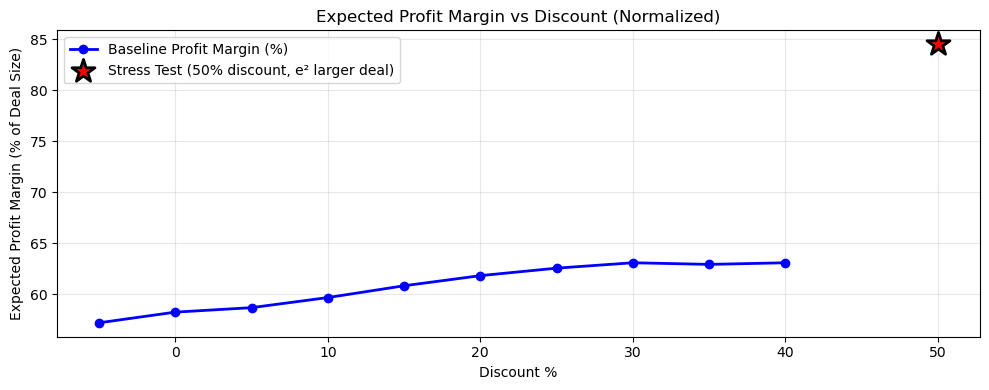

In [65]:
stress["P_LOST"] = stress_pred[:, 0]
stress["P_PENDING"] = stress_pred[:, 1]
stress["P_WON"] = stress_pred[:, 2]

print("Stress test predictions:")
print(stress[["DISCOUNT_PCT_CLIPPED", "LOG_DEAL_SIZE", "P_LOST", "P_PENDING", "P_WON"]])

# Calculate expected profit for stress scenario
# Note: LOG_DEAL_SIZE was increased by 2, so actual deal size is e^2 ≈ 7.39x larger
stress_deal_size = df.loc[baseline.index, "DEAL_SIZE"].values[0] * np.exp(2)
stress_deal_sizes = np.array([stress_deal_size])

print(f"\nBaseline deal size: ${df.loc[baseline.index, 'DEAL_SIZE'].values[0]:,.2f}")
print(f"Stress deal size (e^2 larger): ${stress_deal_size:,.2f}")

# Calculate expected profits and profit margins for baseline scenarios
baseline_deal_size = df.loc[baseline.index, "DEAL_SIZE"].values[0]
results["EXPECTED_PROFIT"] = (
    results["P_WON"] * baseline_deal_size +
    results["P_PENDING"] * 0.4 * baseline_deal_size
)
# Profit margin as % of deal size
results["PROFIT_MARGIN"] = (results["EXPECTED_PROFIT"] / baseline_deal_size) * 100

# Calculate expected profit and margin for stress test
stress_expected_profit = (
    stress["P_WON"].values[0] * stress_deal_size +
    stress["P_PENDING"].values[0] * 0.4 * stress_deal_size
)
stress_profit_margin = (stress_expected_profit / stress_deal_size) * 100

print(f"\nStress Test Expected Profit:")
print(f"  P(WON) = {stress['P_WON'].values[0]:.3f}")
print(f"  P(PENDING) = {stress['P_PENDING'].values[0]:.3f}")
print(f"  P(LOST) = {stress['P_LOST'].values[0]:.3f}")
print(f"  Expected Profit = ${stress_expected_profit:,.2f}")
print(f"  Profit Margin = {stress_profit_margin:.1f}% of deal size")
print(f"  (at {stress['DISCOUNT_PCT_CLIPPED'].values[0]:.0f}% discount)")

# Plot profit margin (%) - normalized for meaningful comparison
plt.figure(figsize=(10, 4))
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["PROFIT_MARGIN"], 
         color='blue', label="Baseline Profit Margin (%)", linewidth=2, marker='o')
plt.scatter(stress["DISCOUNT_PCT_CLIPPED"].values[0], stress_profit_margin, 
           marker='*', s=300, color='red', edgecolors='black', linewidth=2, 
           zorder=5, label='Stress Test (50% discount, e² larger deal)')
plt.xlabel("Discount %")
plt.ylabel("Expected Profit Margin (% of Deal Size)")
plt.title("Expected Profit Margin vs Discount (Normalized)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

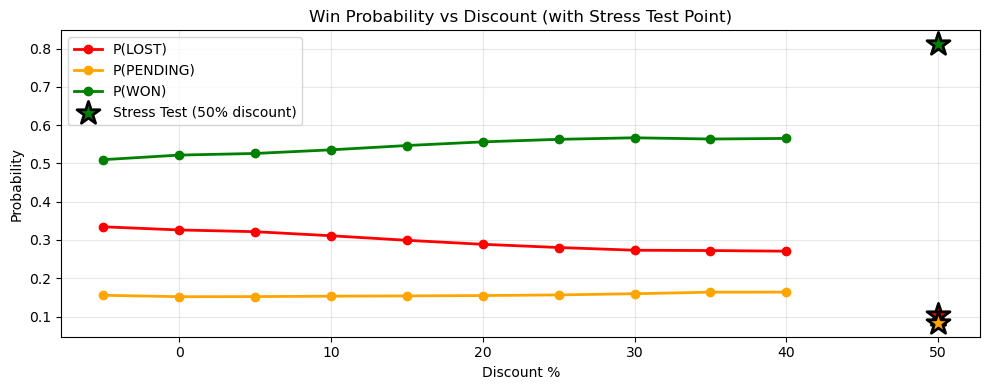

In [66]:
# Plot the discount sweep with stress point overlaid
plt.figure(figsize=(10, 4))

# Plot the baseline sweep as lines
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["P_LOST"], color='red', label="P(LOST)", linewidth=2, marker='o')
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["P_PENDING"], color='orange', label="P(PENDING)", linewidth=2, marker='o')
plt.plot(results["DISCOUNT_PCT_CLIPPED"], results["P_WON"], color='green', label="P(WON)", linewidth=2, marker='o')

# Add the stress point as a star marker
plt.scatter(stress["DISCOUNT_PCT_CLIPPED"], stress["P_LOST"], marker='*', s=300, color='red', edgecolors='black', linewidth=2, zorder=5)
plt.scatter(stress["DISCOUNT_PCT_CLIPPED"], stress["P_PENDING"], marker='*', s=300, color='orange', edgecolors='black', linewidth=2, zorder=5)
plt.scatter(stress["DISCOUNT_PCT_CLIPPED"], stress["P_WON"], marker='*', s=300, color='green', edgecolors='black', linewidth=2, zorder=5, label='Stress Test (50% discount)')

plt.xlabel("Discount %")
plt.ylabel("Probability")
plt.title("Win Probability vs Discount (with Stress Test Point)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
df.shape

(2782, 20)

# Model 3

Build Model 3 as a clean, “time-aware but not time-delusional” model:

- Month encoded cyclically (sin/cos) so December is close to January.

- Quarter treated as categorical (or dropped if redundant).

- Year treated as categorical unless we explicitly want linear trend.

##### Scikit Model

###### The short answer (truthful and blunt)

We’re using scikit-learn instead of TensorFlow because:

- This is a tabular, low-dimensional, probabilistic decision problem — not a representation-learning problem.

TensorFlow would add complexity without adding signal.
Now let’s unpack that carefully.

1. What TensorFlow is actually good at

TensorFlow shines when the model needs to learn representations, not just decisions.

Examples:

- Images → learn spatial features
- Text → learn embeddings
- Audio → learn temporal filters
- Very large datasets → GPU acceleration
- End-to-end pipelines → raw input → prediction

In all of these cases:

- You don’t know the right features in advance, so the network discovers them.

2. What your problem actually is

Your problem has these properties:

- Structured, tabular dat
- ~10–100 engineered features
- Explicit domain features (price, discount, deal size, season)
- Limited data size (not millions of rows)

You care about:

- probabilities
- interpretability
- calibration
- reasoning about why

This is the exact regime where classical statistical learning dominates deep learning.

3. You already did the hard part TensorFlow would normally do

- Look at what you’ve already built:
- LOG_DEAL_SIZE → representation engineering
- PRICE_TO_MSRP_RATIO → domain signal extraction
- MONTH_SIN / MONTH_COS → cyclic structure encoding
- Careful categorical handling
- Feature scaling + validation

This is manual representation learning — and it’s better than what a dense neural network would discover from scratch on limited tabular data.

A neural net would mostly:

- re-learn linear combinations of these features
- overfit minority classes
- produce worse-calibrated probabilities

4. Why logistic regression specifically fits Model 3

Logistic regression is not “simple” here — it’s appropriate.

Because:

- It operates in exactly the transformed space you designed
- Each coefficient has meaning
- Regularization prevents one-hot explosion

Probabilities are:

- well-behaved
- smooth
- calibratable
- And critically:
- Logistic regression fails honestly.
- If it performs poorly, you know the feature space needs richer interactions — not that the optimizer or architecture is wrong.

TensorFlow failures are often ambiguous:

- was it architecture?
- learning rate?
- initialization?
- batch size?
- overfitting?
- optimizer dynamics?

That ambiguity is poison during model understanding.

5. scikit-learn aligns with the questions you’re asking

Look at the questions you’ve been asking throughout this process:

- “What does the model see?”
- “Did scaling distort shape?”
- “Are categories behaving sanely?”
- “Why is probability changing?”
- “Is time encoded correctly?”

These are statistical questions, not deep-learning ones.

scikit-learn gives you:
- transparent pipelines
- inspectable coefficients
- deterministic behavior
- fast iteration
- clean evaluation

TensorFlow would make most of these harder, not easier.

6. When TensorFlow would be the right choice here

There are cases where TensorFlow would make sense for this dataset:

- You have millions of rows
- You want learned embeddings for PRODUCTLINE
- You want nonlinear interactions across many features
- You’re deploying an end-to-end service that consumes raw JSON
- You’ve already exhausted linear + tree-based models
- We’re not there yet — and jumping there early is how models become opaque and fragile.

7. The meta-lesson (this is the real takeaway)

Modeling is not:

- “Which library is more powerful?”

It is:

- “Which tool matches the structure of the uncertainty in my problem?”
- Right now, your uncertainty is:
- overlapping classes
- conditional effects
- probabilistic outcomes
- scikit-learn is built exactly for that regime.

Final verdict

We’re using scikit-learn because:
- You engineered the right features
- You validated the geometry
- You want trustworthy probabilities
- You’re still learning the problem, not brute-forcing it

TensorFlow is a scalpel for learning representations.
Right now, you need a microscope for understanding decisions.

And you’re using the right one.

#### View Data

In [117]:
print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

Shape: (2782, 22)

Columns: ['ORDERDATE', 'YEAR_ID', 'MONTH_ID', 'QTR_ID', 'PRODUCTLINE', 'QUANTITYORDERED', 'MSRP', 'PRICEEACH', 'DISCOUNT_PERCENTAGE', 'DISCOUNT_PCT_CLIPPED', 'DISCOUNT_OUTLIER_FLAG', 'STATUS', 'IS_CLOSED', 'DEAL_SIZE', 'LOG_DEAL_SIZE', 'PRICE_TO_MSRP_RATIO', 'IS_Q4', 'IS_YEAR_END', 'DEAL_SIZE_BUCKETS', 'STATUS_CLASS', 'MONTH_SIN', 'MONTH_COS']


In [118]:
leakage_column_names = [col for col in ["STATUS", "IS_CLOSED"] if col in df.columns]
modeling_dataframe = df.drop(columns=leakage_column_names)

print("\nDropped leakage columns:", leakage_column_names)

print("\nTarget value counts:")
print(modeling_dataframe[TARGET].value_counts(dropna=False))

print("\nTarget missing values:", modeling_dataframe[TARGET].isna().sum())


Dropped leakage columns: ['STATUS', 'IS_CLOSED']

Target value counts:
STATUS_CLASS
2.0    2664
0.0      74
1.0      44
Name: count, dtype: int64

Target missing values: 0


#### Setup Features and Targets

In [119]:
# --- Step 2A: Start from your cleaned df ---
FEATURES = [
    "PRODUCTLINE",
    "QUANTITYORDERED",
    "MSRP",
    "PRICEEACH",
    "DISCOUNT_PCT_CLIPPED",
    "MONTH_ID",
    "YEAR_ID",
    "QTR_ID",
    "LOG_DEAL_SIZE",
    "PRICE_TO_MSRP_RATIO"
]

TARGET = "STATUS_CLASS"
df = df.dropna(subset=FEATURES + [TARGET]).copy()

# --- Step 2B: Create cyclical month features ---
# Why: month is cyclical (12 wraps to 1), sin/cos preserves that geometry.
month_series = df["MONTH_ID"].astype(int)
df["MONTH_SIN"] = np.sin(2 * np.pi * month_series / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * month_series / 12)

# --- Step 2C: Treat year and quarter as categorical ---
# Why: avoids forcing a fake linear distance between categories.
df["YEAR_ID"] = df["YEAR_ID"].astype(int).astype(str)
df["QTR_ID"] = df["QTR_ID"].astype(int).astype(str)

# --- Step 2D: Define final feature columns ---
# IMPORTANT: We REMOVE MONTH_ID after creating sin/cos
final_numeric_features_names = [
    "QUANTITYORDERED",
    "MSRP",
    "PRICEEACH",
    "DISCOUNT_PCT_CLIPPED",
    "LOG_DEAL_SIZE",
    "PRICE_TO_MSRP_RATIO",
    "MONTH_SIN",
    "MONTH_COS",
]

final_categorical_features_names = [
    "PRODUCTLINE",
    "YEAR_ID",
    "QTR_ID",
]

X_df = df[final_categorical_features_names + final_numeric_features_names].copy()
y = df[TARGET].astype("int32").values

# --- Step 2E: Build preprocessing transformer ---
preprocess = ColumnTransformer(
    transformers= [
        ("numerical", StandardScaler(), final_numeric_features_names),
        ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), final_categorical_features_names),
    ],
    remainder="drop",
)

# Optional sanity checks (highly recommended)
print("X_df shape:", X_df.shape)
print("Numeric columns:", final_numeric_features_names)
print("Categorical columns:", final_categorical_features_names)
print("Month_ID min/max:", month_series.min(), month_series.max())

X_df shape: (2782, 11)
Numeric columns: ['QUANTITYORDERED', 'MSRP', 'PRICEEACH', 'DISCOUNT_PCT_CLIPPED', 'LOG_DEAL_SIZE', 'PRICE_TO_MSRP_RATIO', 'MONTH_SIN', 'MONTH_COS']
Categorical columns: ['PRODUCTLINE', 'YEAR_ID', 'QTR_ID']
Month_ID min/max: 1 12


### Strict Transformation

#### Step 1 — Fit the preprocessing transformer (once)

In [120]:
preprocess.fit(X_df)

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['QUANTITYORDERED', 'MSRP', 'PRICEEACH',
                                  'DISCOUNT_PCT_CLIPPED', 'LOG_DEAL_SIZE',
                                  'PRICE_TO_MSRP_RATIO', 'MONTH_SIN',
                                  'MONTH_COS']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['PRODUCTLINE', 'YEAR_ID', 'QTR_ID'])])

#### Step 2 — Transform the data

In [121]:
X_transformed = preprocess.transform(X_df)
print("Transformed X shape:", X_transformed.shape)
print(type(X_transformed))


Transformed X shape: (2782, 22)
<class 'numpy.ndarray'>


#### Step 3 — Recover feature names (this is the key step)

In [122]:
numeric_feature_names = final_numeric_features_names
categorical_encoder = preprocess.named_transformers_["categorical"]
categorical_feature_names = categorical_encoder.get_feature_names_out(
    final_categorical_features_names
)

In [123]:
all_feature_names = list(numeric_feature_names) + list(categorical_feature_names)

In [124]:
len(all_feature_names), X_transformed.shape[1]

(22, 22)

#### Step 4 — Convert to a DataFrame (now you can see it)

In [125]:
X_transformed_df = pd.DataFrame(
    X_transformed,
    columns=all_feature_names,
    index=X_df.index
)
X_transformed_df.head()

,QUANTITYORDERED,MSRP,PRICEEACH,DISCOUNT_PCT_CLIPPED,LOG_DEAL_SIZE,PRICE_TO_MSRP_RATIO,MONTH_SIN,MONTH_COS,PRODUCTLINE_Classic Cars,PRODUCTLINE_Motorcycles,...,PRODUCTLINE_Trains,PRODUCTLINE_Trucks and Buses,PRODUCTLINE_Vintage Cars,YEAR_ID_2003,YEAR_ID_2004,YEAR_ID_2005,QTR_ID_1,QTR_ID_2,QTR_ID_3,QTR_ID_4
0,-0.524210,-0.143411,0.595422,-0.744985,0.132624,0.375647,1.348475,0.442046,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.110991,-0.143411,-0.117943,0.110917,0.041081,-0.181186,0.822187,-1.544817,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.612142,-0.143411,0.547698,-0.687726,0.874675,0.338395,-0.615659,-1.544817,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.025360,-0.143411,-0.022994,-0.003004,0.786111,-0.107071,-1.141947,-1.012439,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.438579,-0.143411,0.809183,-1.001458,1.444909,0.542503,-1.141947,0.442046,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Visualize the Data

##### Metrics dashboard (sanity metrics that catch silent bugs)
These metrics tell you if:

- scaling worked
- the design matrix is sparse
- one-hot columns look reasonable

What “good” looks like:

- means close to 0
- stds close to 1
- sparsity high if you have many categories (normal)

In [126]:
is_sparse = sparse.issparse(X_transformed)
print("Is sparse matrix:", is_sparse)

if is_sparse:
    # Sparsity: fraction of zeros
    nonzero_count = X_transformed.count_nonzero()
    total_count = X_transformed.shape[0] * X_transformed.shape[1]
    sparsity = 1 - (nonzero_count / total_count)
    print(f"Sparsity (fraction zeros): {sparsity:.4f}")

# Numeric columns should be ~mean 0, std 1 (on the fitted data)
X_numeric = X_transformed[:, :len(numeric_feature_names)]
if is_sparse:
    X_numeric_dense = X_numeric.toarray()
else:
    X_numeric_dense = np.asarray(X_numeric)

numeric_means = X_numeric_dense.mean(axis=0)
numeric_stds = X_numeric_dense.std(axis=0)

numeric_metrics_df = pd.DataFrame({
    "feature": numeric_feature_names,
    "mean": numeric_means,
    "std": numeric_stds,
}).sort_values("feature")

display(numeric_metrics_df)
print("\nMean abs(mean):", np.mean(np.abs(numeric_means)))
print("Mean abs(std - 1):", np.mean(np.abs(numeric_stds - 1)))

Is sparse matrix: False


,feature,mean,std
3,DISCOUNT_PCT_CLIPPED,9.924165e-16,1.0
4,LOG_DEAL_SIZE,1.913439e-15,1.0
7,MONTH_COS,7.478641e-17,1.0
6,MONTH_SIN,1.445844e-16,1.0
1,MSRP,2.373690e-16,1.0
2,PRICEEACH,3.773162e-15,1.0
5,PRICE_TO_MSRP_RATIO,7.916026e-16,1.0
0,QUANTITYORDERED,5.355569e-17,1.0



Mean abs(mean): 9.976144042176786e-16
Mean abs(std - 1): 4.73232564246473e-15


##### Plot 1: Heatmap of a small sample (quick “structure” view)
A full heatmap of thousands of rows/cols is unreadable, so we sample.

This shows:
- dense block at the beginning (scaled numerics)
- sparse block after (one-hot)

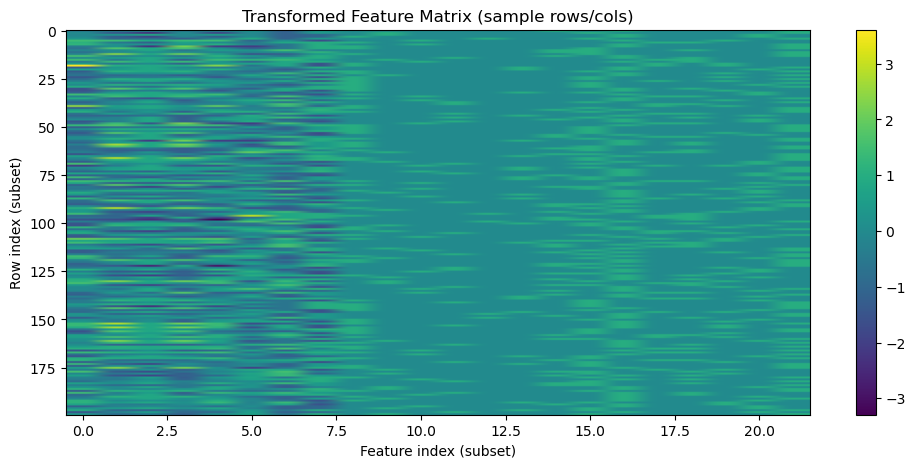

In [127]:
# Visualize a sample of the transformed feature matrix
sample_row_count = 200
sample_col_count = 80

row_indices = np.random.RandomState(42).choice(X_transformed.shape[0], size=min(sample_row_count, X_transformed.shape[0]), replace=False)
col_indices = np.arange(min(sample_col_count, X_transformed.shape[1]))

X_sample = X_transformed[row_indices][:, col_indices]
if sparse.issparse(X_sample):
    X_sample = X_sample.toarray()

plt.figure(figsize=(12, 5))
plt.imshow(X_sample, aspect="auto")
plt.colorbar()
plt.title("Transformed Feature Matrix (sample rows/cols)")
plt.xlabel("Feature index (subset)")
plt.ylabel("Row index (subset)")
plt.show()


##### Plot 2: Distribution of scaled numeric features

You want to see whether scaling produced sane shapes (not NaNs, not crazy spikes).
Healthy-ish:

- centered around 0
- tails exist but not absurd
- no weird single spikes at enormous magnitude

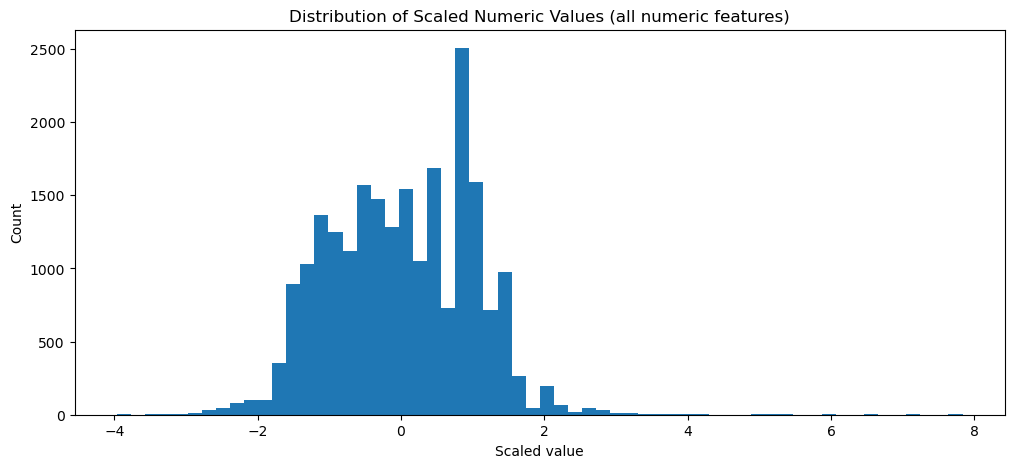

In [128]:
plt.figure(figsize=(12, 5))
plt.hist(X_numeric_dense.flatten(), bins=60)
plt.title("Distribution of Scaled Numeric Values (all numeric features)")
plt.xlabel("Scaled value")
plt.ylabel("Count")
plt.show()

##### Plot 3: PCA 2D scatter (does the transformed space separate classes?)

PCA compresses the transformed space into 2 dimensions so you can eyeball separation.
Interpretation:

- If classes form blobs/clusters: the feature space contains signal.
- If everything is a soup: signal might still exist, but it’s more subtle/nonlinear.

PCA explained variance ratio: [0.29539369 0.17712688]
PCA total explained variance: 0.47252056381594276


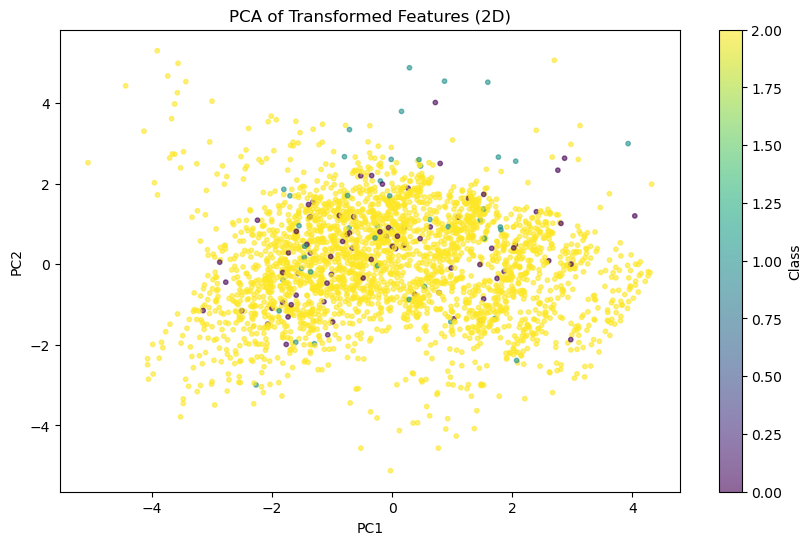

In [129]:
# PCA requires dense arrays; sample if huge
max_rows_for_pca = 5000
rng = np.random.RandomState(42)
row_count = X_transformed.shape[0]

pca_indices = np.arange(row_count)
if row_count > max_rows_for_pca:
    pca_indices = rng.choice(row_count, size=max_rows_for_pca, replace=False)

X_pca_input = X_transformed[pca_indices]
y_pca = np.asarray(y)[pca_indices]

if sparse.issparse(X_pca_input):
    X_pca_input = X_pca_input.toarray()

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_pca_input)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("PCA total explained variance:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, alpha=0.6, c=y_pca)
plt.title("PCA of Transformed Features (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Class")
plt.show()


##### Plot 4: Top one-hot category frequencies (are categories behaving?)
This checks whether one-hot columns look sane (not all zeros, not only one category used, etc.).
This is how you catch:

- category columns that never appear
- weird dominance (like one category appearing 99% of the time)

,feature,count
8,YEAR_ID_2004,1345.0
13,QTR_ID_4,1094.0
7,YEAR_ID_2003,1000.0
0,PRODUCTLINE_Classic Cars,953.0
10,QTR_ID_1,665.0
6,PRODUCTLINE_Vintage Cars,591.0
11,QTR_ID_2,520.0
12,QTR_ID_3,503.0
9,YEAR_ID_2005,437.0
1,PRODUCTLINE_Motorcycles,331.0


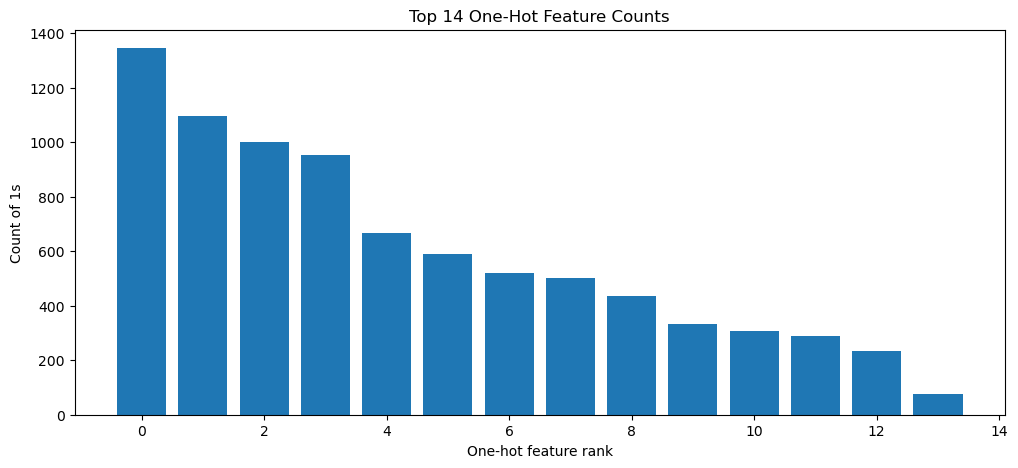

In [130]:
# Extract only the one-hot block
one_hot_start = len(numeric_feature_names)
X_onehot = X_transformed[:, one_hot_start:]
onehot_names = all_feature_names[one_hot_start:]

if sparse.issparse(X_onehot):
    category_counts = np.array(X_onehot.sum(axis=0)).ravel()
else:
    category_counts = X_onehot.sum(axis=0)

onehot_freq_df = pd.DataFrame({
    "feature": onehot_names,
    "count": category_counts
}).sort_values("count", ascending=False)

display(onehot_freq_df.head(20))

# Use actual number of features (min of 20 or available features)
n_features_to_plot = min(20, len(onehot_freq_df))

plt.figure(figsize=(12, 5))
plt.bar(np.arange(n_features_to_plot), onehot_freq_df["count"].values[:n_features_to_plot])
plt.title(f"Top {n_features_to_plot} One-Hot Feature Counts")
plt.xlabel("One-hot feature rank")
plt.ylabel("Count of 1s")
plt.show()


##### Bonus metric: “effective dimensionality” and density
This helps you quantify complexity.

What you’ll learn from these visuals/metrics

- Heatmap: confirms your design matrix structure (dense numerics + sparse one-hot)
- Numeric distribution + mean/std: confirms scaling is correct
- PCA scatter: gives intuition whether the transformed space separates classes
- Top one-hot counts: validates your categorical handling isn’t broken
- Sparsity/density: tells you if the model might prefer linear vs tree-based methods

In [131]:
n_rows, n_cols = X_transformed.shape
print("Rows:", n_rows, "Cols:", n_cols)

if sparse.issparse(X_transformed):
    nnz = X_transformed.count_nonzero()
else:
    nnz = np.count_nonzero(X_transformed)

density = nnz / (n_rows * n_cols)
print(f"Non-zeros: {nnz:,}")
print(f"Density: {density:.6f} (higher = less sparse)")


Rows: 2782 Cols: 22
Non-zeros: 30,602
Density: 0.500000 (higher = less sparse)


##### Extract raw numeric data (before preprocessing)
This shows:

- original units
- scale differences
- skew / heavy tails

In [148]:
X_raw_numeric = X_df[final_numeric_features_names].copy()

print("Raw numeric summary:")
display(X_raw_numeric.describe().T)

Raw numeric summary:


,count,mean,std,min,25%,50%,75%,max
QUANTITYORDERED,2782.0,35.074407,9.681843,6.000000,27.000000,35.000000,43.000000,97.000000
MSRP,2782.0,100.758088,40.158067,33.000000,68.000000,99.000000,124.000000,214.000000
PRICEEACH,2782.0,83.722541,20.119546,27.220000,69.130000,95.800000,100.000000,100.000000
DISCOUNT_PCT_CLIPPED,2782.0,12.410913,17.651511,-10.000000,-2.872565,11.810633,24.242424,50.000000
LOG_DEAL_SIZE,2782.0,7.908753,0.407325,6.295524,7.650169,7.937732,8.220167,9.110427
PRICE_TO_MSRP_RATIO,2782.0,0.905466,0.271320,0.228662,0.757576,0.881894,1.028726,3.030303
MONTH_SIN,2782.0,-0.071818,0.695610,-1.000000,-0.500000,-0.500000,0.500000,1.000000
MONTH_COS,2782.0,0.196081,0.687652,-1.000000,-0.500000,0.500000,0.866025,1.000000


#### Extract normalized numeric data (after preprocessing)

In [150]:
X_scaled_numeric_df = X_transformed_df[final_numeric_features_names]

display(X_scaled_numeric_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
QUANTITYORDERED,2782.0,1.238725e-16,1.00018,-3.003523,-0.834124,-0.007687,0.818751,6.397204
MSRP,2782.0,-1.225954e-16,1.00018,-1.687588,-0.815875,-0.043787,0.578865,2.820411
PRICEEACH,2782.0,3.677863e-16,1.00018,-2.808846,-0.725422,0.600393,0.809183,0.809183
DISCOUNT_PCT_CLIPPED,2782.0,1.225954e-16,1.00018,-1.269860,-0.866001,-0.034013,0.670404,2.129894
LOG_DEAL_SIZE,2782.0,1.695904e-15,1.00018,-3.961256,-0.634949,0.071158,0.764674,2.950692
PRICE_TO_MSRP_RATIO,2782.0,-4.903818e-16,1.00018,-2.494938,-0.545176,-0.086897,0.454377,7.832892
MONTH_SIN,2782.0,8.939251e-18,1.00018,-1.334582,-0.615659,-0.615659,0.822187,1.541110
MONTH_COS,2782.0,-5.108143e-18,1.00018,-1.739681,-1.012439,0.442046,0.974425,1.169289


#### Plot raw vs normalized distributions (feature by feature)

##### A. Overlayed histograms (most intuitive)
This answers: “What did scaling actually do to the shape?”

How to interpret this

- Shape should be similar, just shifted and rescaled
- Skew remains (scaling ≠ normalization of distribution)
- Outliers remain (scaling ≠ clipping)

That’s exactly what StandardScaler is supposed to do.

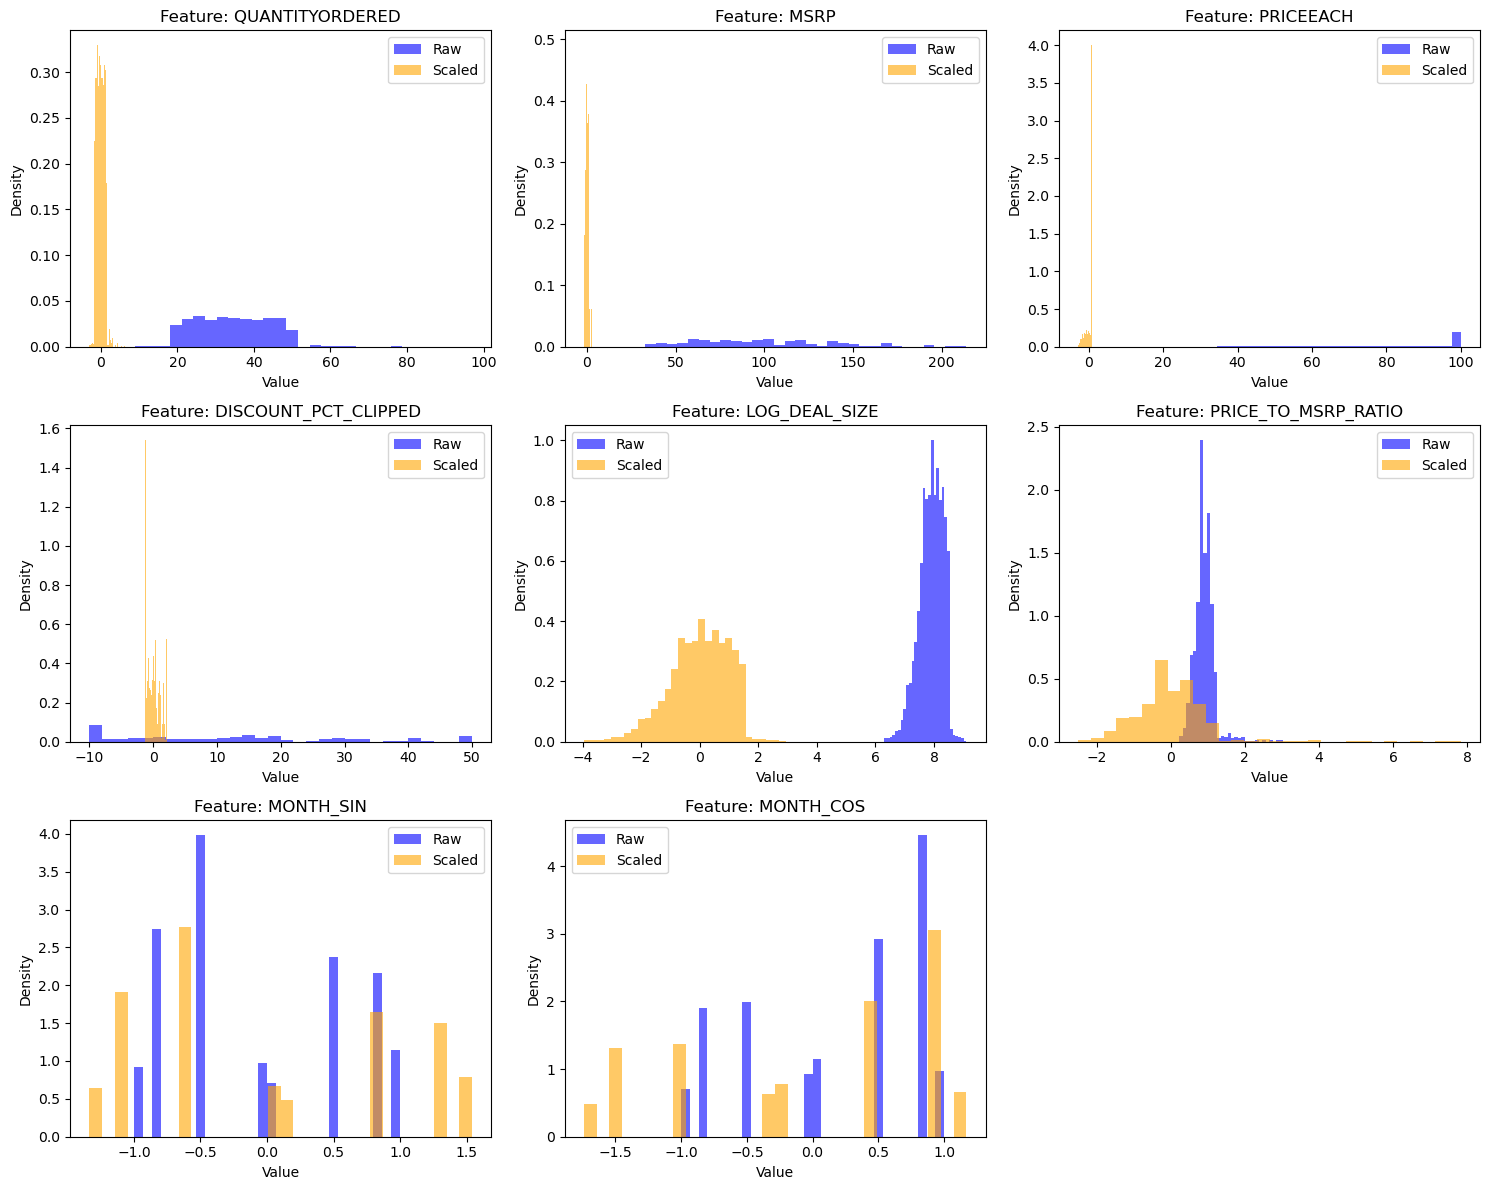

In [151]:
num_featuers = len(final_numeric_features_names)
cols = 3
rows = (num_featuers + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 4))

for i, feature in enumerate(final_numeric_features_names):
    plt.subplot(rows, cols, i + 1)
    plt.hist(
        X_raw_numeric[feature],
        bins=30,
        alpha=0.6,
        label="Raw",
        color="blue",
        density=True,
    )
    plt.hist(
        X_scaled_numeric_df[feature],
        bins=30,
        alpha=0.6,
        label="Scaled",
        color="orange",
        density=True,
    )

    plt.title(f"Feature: {feature}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    
plt.tight_layout()
plt.show()

##### Metric comparison table (numerical proof)
This makes the effect undeniable.
If you see this → preprocessing is correct and stable.

In [152]:
comparison_df = pd.DataFrame({
    "raw_mean": X_raw_numeric.mean(),
    "raw_std": X_raw_numeric.std(),
    "scaled_mean": X_scaled_numeric_df.mean(),
    "scaled_std": X_scaled_numeric_df.std(),
}).round(4)

display(comparison_df)


,raw_mean,raw_std,scaled_mean,scaled_std
QUANTITYORDERED,35.0744,9.6818,0.0,1.0002
MSRP,100.7581,40.1581,0.0,1.0002
PRICEEACH,83.7225,20.1195,0.0,1.0002
DISCOUNT_PCT_CLIPPED,12.4109,17.6515,0.0,1.0002
LOG_DEAL_SIZE,7.9088,0.4073,0.0,1.0002
PRICE_TO_MSRP_RATIO,0.9055,0.2713,0.0,1.0002
MONTH_SIN,-0.0718,0.6956,0.0,1.0002
MONTH_COS,0.1961,0.6877,0.0,1.0002


##### One global sanity plot (optional but powerful)
This answers: “Did scaling fix magnitude dominance?”
This plot alone usually convinces people why scaling matters.

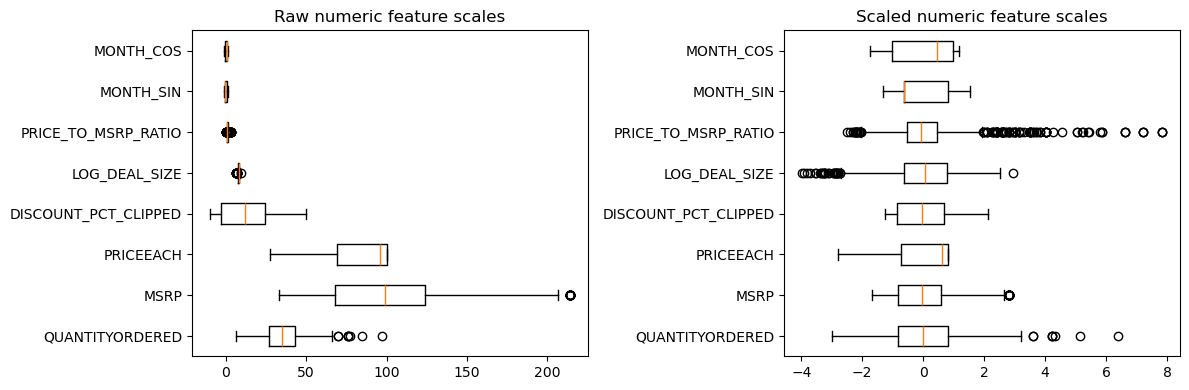

In [154]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.boxplot(X_raw_numeric.values, vert=False)
plt.title("Raw numeric feature scales")
plt.yticks(range(1, len(final_numeric_features_names) + 1), final_numeric_features_names)

plt.subplot(1, 2, 2)
plt.boxplot(X_scaled_numeric_df.values, vert=False)
plt.title("Scaled numeric feature scales")
plt.yticks(range(1, len(final_numeric_features_names) + 1), final_numeric_features_names)

plt.tight_layout()
plt.show()


#### Train a baseline model that matches the data geometry

##### Step 4.0 — Why this model, before any others

Based on everything you’ve validated:

- Features are well-scaled
- Many features are one-hot (sparse, linear-friendly)
- Signal is overlapping and conditional, not cleanly separable
- You care about probabilities, not just accuracy
- You want to compare fairly against Models 1 & 2

The correct first model is:

- Regularized multinomial logistic regression

Why?

- It respects linear combinations of your carefully engineered features
- It produces calibrated class probabilities
- Coefficients are interpretable
- It gives us a reference point for whether more complex models are justified

If this model fails, it fails honestly — and that tells us something.

##### Step 4.1 — Define the model (no training yet)
We use:

- multinomial → because you have 3 classes
- lbfgs → stable optimizer for this regime
- C < 1 → regularization to prevent overfitting on one-hot features

Why C=0.5?

- You have many correlated features
- This dampens coefficient explosion
- We will tune later if needed

In [171]:
logistic_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    C=.5,
    n_jobs=-1,
    penalty="l2",
    fit_intercept=True,
)

#### Step 4.2 — Build the full pipeline (this is critical)

This locks preprocessing + model together so:

- no leakage
- no mismatch
- reproducible evaluation

This is now a single object that:

- takes raw X_df
- outputs class probabilities

In [172]:
model_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("logistic_model", logistic_model)
    ]
)

#### Step 4.3 — Train / test split (if not already done)

Stratification matters because your PCA already showed class imbalance.

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

#### Step 4.4 — Fit the model (first real training)

At this point:

- preprocessing stats are learned from train only
- logistic coefficients are learned on transformed features

No evaluation yet. We stop here intentionally.

In [173]:
model_pipeline.fit(X_train, y_train)

c:\Users\pwong\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['QUANTITYORDERED', 'MSRP',
                                                   'PRICEEACH',
                                                   'DISCOUNT_PCT_CLIPPED',
                                                   'LOG_DEAL_SIZE',
                                                   'PRICE_TO_MSRP_RATIO',
                                                   'MONTH_SIN', 'MONTH_COS']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['PRODUCTLINE', 'YEAR_ID',
                                                   'QTR_ID'])])),
                ('logistic_model',
                 LogisticRegression(C=0.5, max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1))])

#### Step 4.5 — Sanity checks (before metrics)

These checks catch subtle but deadly bugs.

Check predicted probability shape

In [169]:
y_proba_train = model_pipeline.predict_proba(X_train)
y_proba_test = model_pipeline.predict_proba(X_test)

print("Train proba shape:", y_proba_train.shape)
print("Test proba shape:", y_proba_test.shape)


Train proba shape: (2225, 3)
Test proba shape: (557, 3)


Check probabilities sum to 1

In [170]:
print("Max deviation from 1:",
      abs(y_proba_test.sum(axis=1) - 1).max())

Max deviation from 1: 2.220446049250313e-16


#### Mental roadmap (what we’re about to visualize)

The formula has three conceptual steps:

Linear score:

- s^k=wk⋅x+bk

Exponentiation:

- e^sk

Normalization (competition):
- divide by the sum → probability

We’ll visualize each step.

##### Visualization 1 — Linear scores as straight lines (the foundation)

Let’s pretend:

- We only have one feature: DISCOUNT_PCT_CLIPPED
- Three classes: LOST, PENDING, WON
- What this shows
- Each class has a line
- The height of the line = evidence for that class
- No probabilities yet

What to understand

- These are not probabilities
- The highest line at a point = strongest explanation
- Intersections = decision boundaries

This alone explains why scaling mattered:
if one feature dominates, these lines tilt wildly.

1.7
-2.3


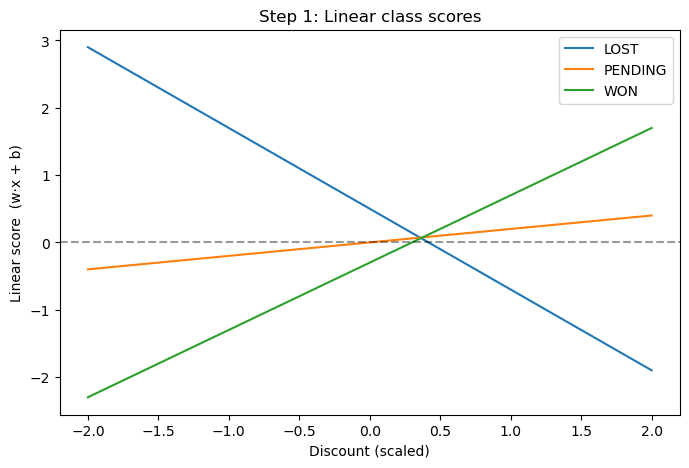

In [186]:
# One feature: discount
x = np.linspace(-2, 2, 400)

# Fake learned weights (for intuition)
weights = {
    "LOST":    (-1.2,  0.5),
    "PENDING": ( 0.2,  0.0),
    "WON":     ( 1.0, -0.3),
}

plt.figure(figsize=(8, 5))

for label, (w, b) in weights.items():
    score = w * x + b
    plt.plot(x, score, label=label)
print(max(score))
print(min(score))

plt.axhline(0, color="black", linestyle="--", alpha=0.4)
plt.xlabel("Discount (scaled)")
plt.ylabel("Linear score  (w·x + b)")
plt.title("Step 1: Linear class scores")
plt.legend()
plt.show()


##### Visualization 2 — Exponentiation (why small differences matter)

Now we apply the exponential.

What this shows

- Positive scores explode upward
- Negative scores collapse toward zero
- Relative differences get amplified

What to understand

Exponentiation turns evidence into strength

- One class can dominate even if scores differ slightly
- This is why probabilities can change sharply
- At this stage, numbers still don’t sum to 1.

5.4739473917272
0.10025884372280375


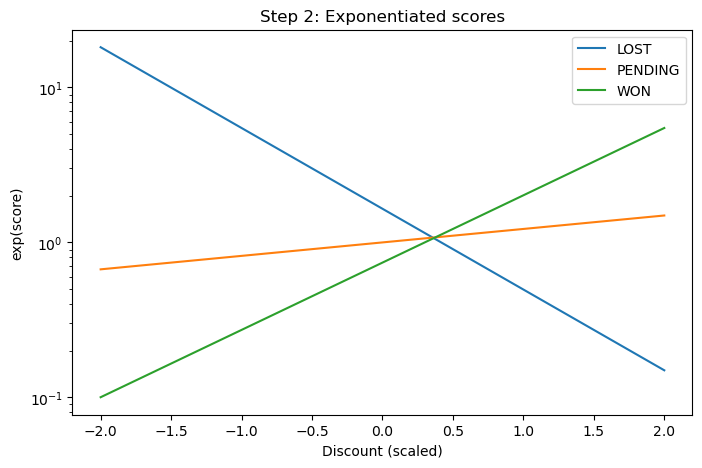

In [185]:
plt.figure(figsize=(8, 5))

for label, (w, b) in weights.items():
    score = w * x + b
    exp_score = np.exp(score)
    plt.plot(x, exp_score, label=label)
print(max(exp_score))
print(min(exp_score))

plt.xlabel("Discount (scaled)")
plt.ylabel("exp(score)")
plt.title("Step 2: Exponentiated scores")
plt.yscale("log")
plt.legend()
plt.show()


##### Visualization 3 — Softmax probabilities (the full picture)

Now we normalize — this is the actual formula you asked about.

What to understand

- Probabilities sum to 1 at every x
- Classes compete — one goes up, others go down
- Smooth curves = smooth decision logic

This plot is exactly what your real model is doing — just in higher dimensions.

Probabilities shape: (3, 400)
[[0.95932488 0.95873227 0.95813111 ... 0.02187367 0.02144309 0.02102058]
 [0.03538294 0.03586088 0.03634493 ... 0.21213302 0.2108965  0.20966314]
 [0.00529218 0.00540685 0.00552396 ... 0.76599331 0.7676604  0.76931627]]


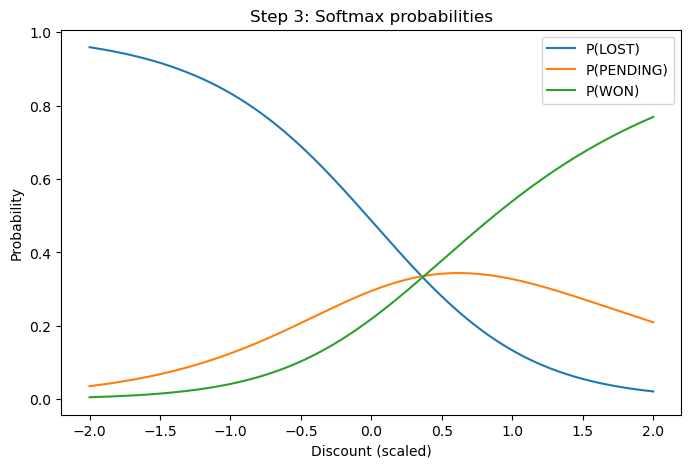

In [196]:
# Compute all scores
scores = np.vstack([
    weights["LOST"][0] * x + weights["LOST"][1],
    weights["PENDING"][0] * x + weights["PENDING"][1],
    weights["WON"][0] * x + weights["WON"][1],
])

# Softmax
exp_scores = np.exp(scores)
probabilities = exp_scores / exp_scores.sum(axis=0)
print("Probabilities shape:", probabilities.shape)
print(probabilities)  # first 5 columns

plt.figure(figsize=(8, 5))
plt.plot(x, probabilities[0], label="P(LOST)")
plt.plot(x, probabilities[1], label="P(PENDING)")
plt.plot(x, probabilities[2], label="P(WON)")

plt.xlabel("Discount (scaled)")
plt.ylabel("Probability")
plt.title("Step 3: Softmax probabilities")
plt.legend()
plt.show()


##### Visualization 4 — Decision regions (2 features, optional but powerful)

Now let’s go 2D, which maps directly to your intuition.

Let’s use:

- LOG_DEAL_SIZE
- DISCOUNT_PCT_CLIPPED

What to understand

- Space is partitioned into regions
- Boundaries are linear (but probabilities are smooth)
- Moving a point changes which surface dominates

This is literally what happens when you tweak:

- discount
- deal size
- seasonality

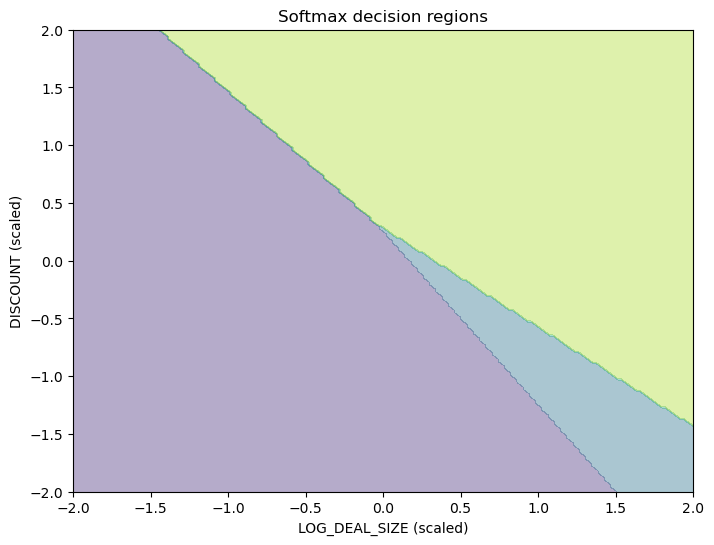

In [ ]:
# 2D grid
x1 = np.linspace(-2, 2, 200)
x2 = np.linspace(-2, 2, 200)
X1, X2 = np.meshgrid(x1, x2)

# Fake weights for 2 features
W = {
    "LOST":    np.array([-1.0, -0.5]),
    "PENDING": np.array([ 0.2,  0.3]),
    "WON":     np.array([ 0.8,  1.0]),
}
B = {
    "LOST": 0.2,
    "PENDING": 0.0,
    "WON": -0.2,
}

scores = np.zeros((3, X1.size))

for i, label in enumerate(["LOST", "PENDING", "WON"]):
    scores[i] = (
        W[label][0] * X1.ravel()
        + W[label][1] * X2.ravel()
        + B[label]
    )

exp_scores = np.exp(scores)
probs = exp_scores / exp_scores.sum(axis=0)

pred_class = np.argmax(probs, axis=0)
Z = pred_class.reshape(X1.shape)

plt.figure(figsize=(8, 6), )
plt.contourf(X1, X2, Z, levels=3, alpha=0.4)
plt.xlabel("LOG_DEAL_SIZE (scaled)")
plt.ylabel("DISCOUNT (scaled)")
plt.title("Softmax decision regions")
plt.show()


##### The big takeaway (this is the one to remember)

Logistic regression builds linear “evidence surfaces”,
exponentiates them to express confidence,
then normalizes them into probabilities via competition.

Every graph you just saw is:

- happening simultaneously
- in dozens of dimensions
- for every prediction

Once you can see this, coefficient tables, probability curves, and calibration plots suddenly make sense.

If you want, the next natural step is:

- visualizing your real model’s coefficients, or
- plotting P(WON), P(PENDING), P(LOST) against one real feature (like discount)
- Both map directly onto what you just saw.

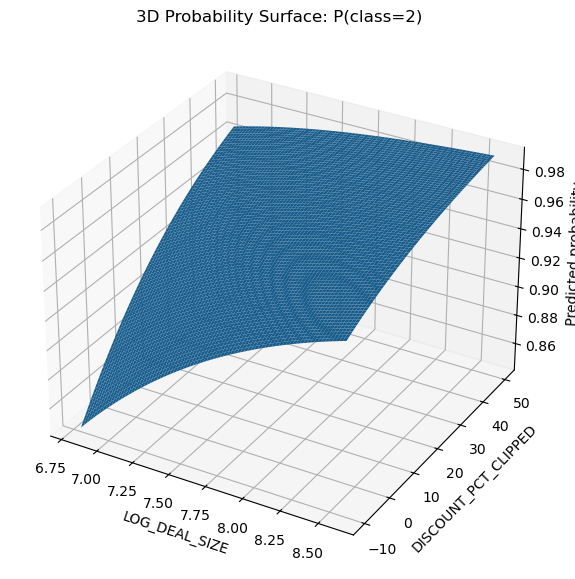

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Choose two raw features to vary (these should exist in X_df)
x_feature_name = "LOG_DEAL_SIZE"
y_feature_name = "DISCOUNT_PCT_CLIPPED"

# Build a "baseline" row: typical values for all other features
baseline_row = X_df.iloc[0].copy()

# For numeric columns: use median
numeric_columns = X_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    baseline_row[col] = X_df[col].median()

# For categorical columns: use mode (most common)
categorical_columns = X_df.columns.difference(numeric_columns)
for col in categorical_columns:
    baseline_row[col] = X_df[col].mode(dropna=True).iloc[0]

# Create a grid in raw feature units (not scaled; pipeline handles scaling)
x_values = np.linspace(X_df[x_feature_name].quantile(0.01), X_df[x_feature_name].quantile(0.99), 80)
y_values = np.linspace(X_df[y_feature_name].quantile(0.01), X_df[y_feature_name].quantile(0.99), 80)

X_grid, Y_grid = np.meshgrid(x_values, y_values)

# Build grid dataframe for prediction
grid_rows = []
for x_val, y_val in zip(X_grid.ravel(), Y_grid.ravel()):
    row = baseline_row.copy()
    row[x_feature_name] = x_val
    row[y_feature_name] = y_val
    grid_rows.append(row)

grid_df = pd.DataFrame(grid_rows, columns=X_df.columns)

# Predict probabilities
proba = model_pipeline.predict_proba(grid_df)

# Pick which class probability to plot
# If your classes are encoded as 0,1,2, choose the class index you want:
class_index_to_plot = 2  # example: 2 might be WON depending on your encoding
Z = proba[:, class_index_to_plot].reshape(X_grid.shape)

# Plot surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X_grid, Y_grid, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)

ax.set_title(f"3D Probability Surface: P(class={class_index_to_plot})")
ax.set_xlabel(x_feature_name)
ax.set_ylabel(y_feature_name)
ax.set_zlabel("Predicted probability")

plt.show()


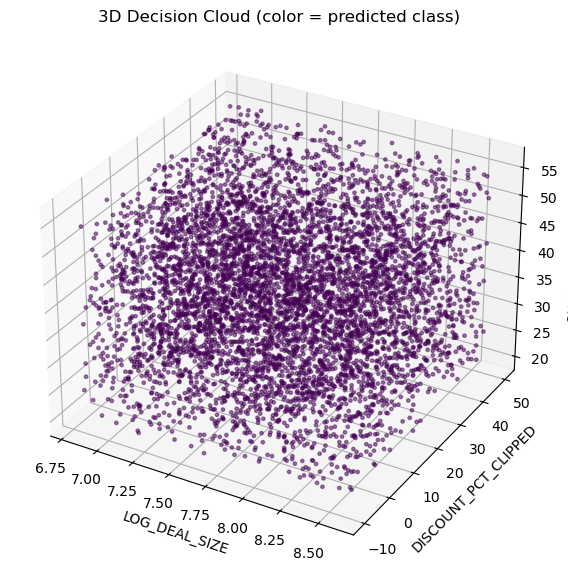

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Pick 3 raw numeric features
f1, f2, f3 = "LOG_DEAL_SIZE", "DISCOUNT_PCT_CLIPPED", "QUANTITYORDERED"

baseline_row = X_df.iloc[0].copy()

numeric_columns = X_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    baseline_row[col] = X_df[col].median()

categorical_columns = X_df.columns.difference(numeric_columns)
for col in categorical_columns:
    baseline_row[col] = X_df[col].mode(dropna=True).iloc[0]

# Sample points in a 3D box (use quantiles to avoid extreme outliers)
n_points = 6000
rng = np.random.RandomState(42)

f1_vals = rng.uniform(X_df[f1].quantile(0.01), X_df[f1].quantile(0.99), n_points)
f2_vals = rng.uniform(X_df[f2].quantile(0.01), X_df[f2].quantile(0.99), n_points)
f3_vals = rng.uniform(X_df[f3].quantile(0.01), X_df[f3].quantile(0.99), n_points)

rows = []
for a, b, c in zip(f1_vals, f2_vals, f3_vals):
    row = baseline_row.copy()
    row[f1], row[f2], row[f3] = a, b, c
    rows.append(row)

cloud_df = pd.DataFrame(rows, columns=X_df.columns)

proba = model_pipeline.predict_proba(cloud_df)
pred = np.argmax(proba, axis=1)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(f1_vals, f2_vals, f3_vals, c=pred, s=6, alpha=0.5)

ax.set_title("3D Decision Cloud (color = predicted class)")
ax.set_xlabel(f1)
ax.set_ylabel(f2)
ax.set_zlabel(f3)

plt.show()


#### Step 5 — Evaluate Model 3 properly

We will answer four questions, in order:

- Can it classify at all? (sanity)
- Where does it make mistakes? (confusion)
- How good are the probabilities? (calibration)
- How does it compare to Models 1 & 2 conceptually?

We do not tune anything yet.

##### Step 5.1 — Basic predictions (sanity check)

What this tells you

- The model is wired correctly
- It predicts all classes (or not — that’s important)
- Accuracy is just a baseline, not the goal

If accuracy is “meh”, that’s fine. This is not a linearly separable problem.

In [200]:
from sklearn.metrics import accuracy_score

y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Predicted class counts:", dict(zip(*np.unique(y_pred, return_counts=True))))


Accuracy: 0.9569120287253142
Predicted class counts: {np.int32(0): np.int64(1), np.int32(1): np.int64(1), np.int32(2): np.int64(555)}


##### Step 5.2 — Confusion matrix (where errors happen)

This shows who the model confuses with whom.

How to read this

- Diagonal → correct predictions
- Off-diagonal → structured mistakes

Pay attention to:

- LOST ↔ PENDING confusion (expected)
- WON ↔ PENDING confusion (expected)
- LOST ↔ WON confusion (more concerning)

This matrix tells you where uncertainty lives.

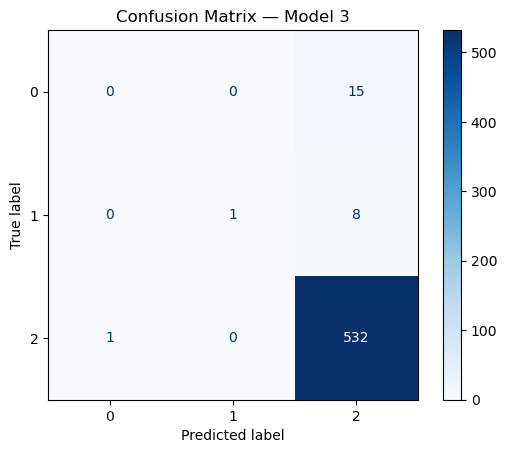

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Model 3")
plt.show()


#### Step 5.3 — Precision / Recall / F1 (class-by-class)

In [203]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       1.00      0.11      0.20         9
           2       0.96      1.00      0.98       533

    accuracy                           0.96       557
   macro avg       0.65      0.37      0.39       557
weighted avg       0.93      0.96      0.94       557



##### Step 5.4 — Probability sanity check (this is critical)

Interpretation:

- Min ≈ 0 → expected
- Max ≈ 1 → expected
- Mean max prob:
    - ~0.5 → very uncertain model
    - ~0.9 → very confident model

Neither extreme is automatically good or bad.

Before calibration curves, do this:

In [204]:
print("Min prob:", y_proba.min())
print("Max prob:", y_proba.max())
print("Mean max prob per row:", np.mean(y_proba.max(axis=1)))


Min prob: 9.547373005196204e-06
Max prob: 0.9999351133045177
Mean max prob per row: 0.957847579991503


##### Step 5.5 — Reliability / Calibration curves (the probability test)

This answers:

- “When the model says 70%, is it right about 70% of the time?”

We’ll plot one class at a time.

How to interpret this

- Line near diagonal → well calibrated
- Curve above diagonal → underconfident
- Curve below diagonal → overconfident

This is where logistic regression often shines.

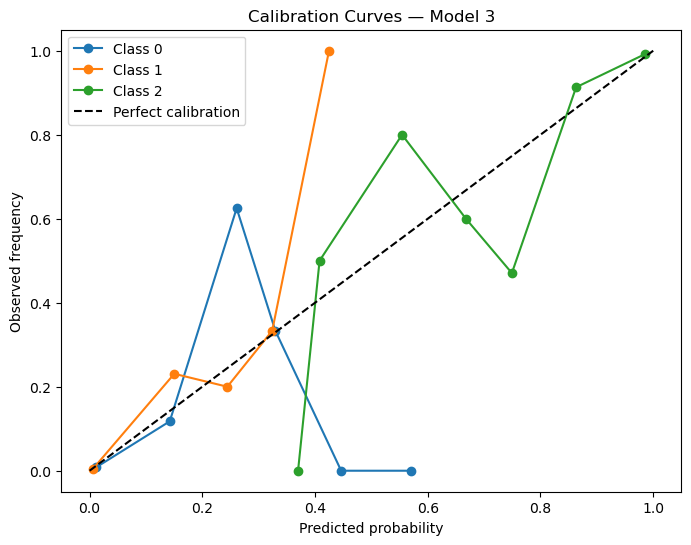

In [207]:
plt.figure(figsize=(8, 6))

for class_idx, label in enumerate(["Class 0", "Class 1", "Class 2"]):
    prob_true, prob_pred = calibration_curve(
        (y_test == class_idx).astype(int),
        y_proba[:, class_idx],
        n_bins=10,
    )
    plt.plot(prob_pred, prob_true, marker="o", label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curves — Model 3")
plt.legend()
plt.show()


##### Step 5.6 — Log loss (the real probabilistic metric)

Accuracy ignores probabilities. Log loss does not.
Lower = better
This is the metric that punishes confident wrong predictions.

In [210]:
print("Log loss:", log_loss(y_test, y_proba))


Log loss: 0.11796076468567969


##### Takeaways

What we have not done (intentionally)

- No hyperparameter tuning
- No class weighting
- No threshold hacking
- No boosting

This is a clean baseline.
The evaluation mindset (important)

If Model 3 shows:

- reasonable accuracy
- structured confusion
- smooth calibration
- sane probability spread

Then it is doing exactly what it should.

If it fails:

- that tells us what kind of model we need next
- not that this one was “bad”